# Clasificación explicable de arritmias cardíacas a partir de electrocardiogramas transformados en espectrogramas mediante redes neuronales convolucionales

## Resumen
Este proyecto aborda la detección y clasificación de arritmias cardíacas a partir de señales de ECG crudas, transformadas en representaciones tiempo–frecuencia (espectrogramas), y analizadas con redes neuronales convolucionales (CNN). Se persigue un enfoque **explicable** que permita interpretar qué patrones del espectrograma sustentan las decisiones del modelo, aportando trazabilidad clínica y robustez metodológica.

## Objetivos
- **O1.** Construir un *pipeline* reproducible que convierta segmentos de ECG crudos en **espectrogramas**.
- **O2.** Entrenar y comparar tres arquitecturas CNN de referencia (**ResNet**, **MobileNet**, **EfficientNet**) para clasificación de arritmias.
- **O3.** Incorporar técnicas de **explicabilidad** (p. ej., Grad-CAM) para visualizar regiones relevantes en los espectrogramas.
- **O4.** Evaluar con métricas centradas en clases minoritarias (macro-F1, F1 por clase) y con **partición 70/15/15** estratificada y **agrupada por registro/paciente** para evitar *data leakage*.

## Contribución
1. **Pipeline extremo a extremo** desde ECG crudo → espectrograma → entrenamiento → explicabilidad.
2. **Evaluación justa** con división 70/15/15 sin fuga entre conjuntos (agrupación por `record_id`/paciente).
3. **Análisis comparativo** entre ResNet, MobileNet y EfficientNet con el mismo preprocesamiento.
4. **Explicabilidad** mediante mapas de activación sobre espectrogramas para interpretación clínica.

## Conjunto de datos
Se emplea **MIT-BIH Arrhythmia Database** (PhysioNet), accedido localmente desde `./mit-bih-arrhythmia-database-1.0.0`. El uso incluye:
- Lectura de señales y anotaciones (WFDB).
- Segmentación por latidos o ventanas deslizantes (p. ej., 2.5–5 s).
- Etiquetado según taxonomía AAMI u otra definida en el proyecto.
> Nota: se normalizarán frecuencias de muestreo y amplitudes para asegurar consistencia entre registros.

## Metodología (vista general)
1. **Preprocesamiento**: (opcional) filtrado banda 0.5–40 Hz y corrección de línea base; normalización por ventana.
2. **Representación**: cálculo de **espectrogramas** (p. ej., STFT/CWT), escala logarítmica y reescalado a tamaño estándar (p. ej., 224×224).
3. **Modelado**: *fine-tuning* de **ResNet**, **MobileNet** y **EfficientNet** (entrada 3 canales; el espectrograma en gris se replica a 3 canales).
4. **Entrenamiento**: **CrossEntropy** con **pesos por clase**, optimizador AdamW, *early stopping* por macro-F1.
5. **Evaluación**: accuracy, **macro-F1**, F1 por clase, matriz de confusión; reporte por clases AAMI.
6. **Explicabilidad**: Grad-CAM/Grad-CAM++ para visualizar regiones discriminativas del espectrograma.
7. **Reproducibilidad**: semillas fijadas, guardado de *splits*, pesos y *configs*.

## Partición de datos
Se aplicará una división **70%/15%/15%** con:
- **Estratificación por clase** (mantener proporciones).
- **Agrupación por `record_id`/paciente** (ningún registro se repite en train/val/test).

## Métricas y validación
- **Métrica principal**: **macro-F1** en validación/test.
- **Métricas secundarias**: F1 por clase, accuracy y matriz de confusión.
- (Opcional) Intervalos de confianza vía *bootstrap* para robustez estadística.

## Organización del notebook
1. **0. Configuración y utilidades**
2. **1. Carga de datos (WFDB) y segmentación**
3. **2. Preprocesamiento y generación de espectrogramas**
4. **3. Partición estratificada y agrupada (70/15/15)**
5. **4. Modelos (ResNet/MobileNet/EfficientNet)**
6. **5. Entrenamiento y *tuning***
7. **6. Evaluación y resultados**
8. **7. Explicabilidad (Grad-CAM)**
9. **8. Conclusiones y trabajo futuro**

---

> **Reproducibilidad**: Este notebook fija semillas aleatorias y guarda los índices de división, parámetros y pesos entrenados. Se recomienda versionar resultados (p. ej., `wandb/mlflow` o JSONs en disco).

In [1]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.cuda.amp")

In [3]:
import torch
print("Versión de PyTorch:", torch.__version__)
print("Versión de CUDA:", torch.version.cuda)
print("cuDNN:", torch.backends.cudnn.version())
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU detectada:", torch.cuda.get_device_name(0))


Versión de PyTorch: 2.6.0+cu124
Versión de CUDA: 12.4
cuDNN: 90100
CUDA disponible: True
GPU detectada: NVIDIA GeForce GTX 1660 Ti


In [4]:
# ==== 0. Configuración y utilidades ====
import os, random, numpy as np
import torch

# Ruta local al dataset (ajústala si cambias la ubicación)
DATA_DIR = "./mit-bih-arrhythmia-database-1.0.0"

# Comprobaciones básicas
assert os.path.isdir(DATA_DIR), f"No se encontró el directorio: {DATA_DIR}. Verifica la ruta."

# Semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("DATA_DIR:", os.path.abspath(DATA_DIR))
print("CUDA disponible:", torch.cuda.is_available())

DATA_DIR: C:\Users\luisa\Documents\Titulacion_UEES\GitHub_Titulacion\TITULACION_UEES\Notebooks\MIT_BIH_DATABASE_NOTEBOOK\mit-bih-arrhythmia-database-1.0.0
CUDA disponible: True


# Sección 1 — Carga de datos (WFDB)

In [5]:
# --- Sección 1: Utilidades WFDB + AAMI + build_df_beats ---
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import wfdb
from typing import List, Iterable, Optional, Set, Tuple

# 1) Descubrir registros
def list_records(data_dir: str) -> List[str]:
    """
    Devuelve IDs de registro (p.ej., '100', '101') a partir de:
    - Archivo RECORDS, si existe.
    - Intersección de *.hea y *.dat, si no existe RECORDS.
    """
    d = Path(data_dir)
    records_file = d / "RECORDS"
    if records_file.is_file():
        return [Path(ln.strip()).name for ln in records_file.read_text().splitlines() if ln.strip()]

    heas = {Path(p).stem for p in glob.glob(str(d / "*.hea"))}
    dats = {Path(p).stem for p in glob.glob(str(d / "*.dat"))}
    recs = sorted(heas & dats)
    if not recs:
        raise FileNotFoundError(f"No se encontraron registros en {data_dir}")
    return recs

# 2) Mapeo MIT-BIH → AAMI
AAMI_MAP = {
    "N":"N","L":"N","R":"N","e":"N","j":"N",
    "A":"S","a":"S","J":"S","S":"S",
    "V":"V","E":"V",
    "F":"F",
    "f":"Q","/":"Q","Q":"Q","?":"Q","~":"Q","|":"Q","x":"Q","B":"Q","p":"Q","t":"Q"
}
AAMI_VALID: Set[str] = {"N","S","V","F","Q"}

def mitbih_symbol_to_aami(sym: str) -> str:
    return AAMI_MAP.get(sym, "Q")

# 3) Lectura de registro
def load_record(record_id: str, data_dir: str) -> Tuple[np.ndarray, int, np.ndarray, np.ndarray]:
    """
    Retorna:
      - sig: float32, shape [n_muestras, n_canales]
      - fs: int
      - ann_samples: int64 [n_ann]
      - ann_symbols: str  [n_ann]
    """
    rec_path = str(Path(data_dir) / record_id)

    sig, fs = None, None
    try:
        rec = wfdb.rdrecord(rec_path)
        sig = np.asarray(rec.p_signal, dtype=np.float32)
        fs  = int(rec.fs)
    except Exception:
        # respaldo: rdsamp
        signals, fields = wfdb.rdsamp(rec_path)
        sig = np.asarray(signals, dtype=np.float32)
        fs  = int(fields.get("fs") or fields.get("fsamp") or fields["fs"])

    try:
        ann = wfdb.rdann(rec_path, "atr")
        ann_samples = ann.sample.astype(np.int64)
        ann_symbols = np.asarray(ann.symbol)
    except Exception:
        ann_samples = np.empty(0, dtype=np.int64)
        ann_symbols = np.empty(0, dtype=str)

    # Garantizar 2D
    if sig.ndim == 1:
        sig = sig[:, None]
    return sig, fs, ann_samples, ann_symbols

# 4) Construcción de df_beats
def build_df_beats(records: Iterable[str],
                   data_dir: str,
                   use_channel: int = 0,
                   keep_aami: Optional[Set[str]] = None) -> pd.DataFrame:
    """
    Crea un DataFrame con una fila por latido anotado perteneciente a AAMI {N,S,V,F,Q}.
    Columnas: record_id, fs, sample_index, symbol, aami, n_samples_record, channel
    """
    keep = AAMI_VALID if keep_aami is None else set(keep_aami)
    rows = []
    to_aami = np.frompyfunc(lambda s: AAMI_MAP.get(s, "Q"), 1, 1)

    for rid in records:
        sig, fs, ann_idx, ann_sym = load_record(rid, data_dir)
        # Saltar registros sin anotaciones
        if ann_idx.size == 0:
            continue
        # Validar canal existente
        n_ch = sig.shape[1]
        if use_channel >= n_ch:
            raise ValueError(f"Canal {use_channel} no existe en {rid} (tiene {n_ch}).")

        # Mapear símbolos → AAMI y filtrar
        aami_arr = to_aami(ann_sym).astype(str)
        mask = np.isin(aami_arr, list(keep))
        if not np.any(mask):
            continue

        sel_idx = ann_idx[mask].astype(int)
        sel_sym = ann_sym[mask].astype(str)
        sel_aam = aami_arr[mask].astype(str)

        n_samples = sig.shape[0]
        rows.extend({
            "record_id": rid,
            "fs": fs,
            "sample_index": int(si),
            "symbol": sy,
            "aami": am,
            "n_samples_record": n_samples,
            "channel": use_channel
        } for si, sy, am in zip(sel_idx, sel_sym, sel_aam))

    df = pd.DataFrame(rows)
    return df.sort_values(["record_id", "sample_index"]).reset_index(drop=True) if not df.empty else df

# Ejemplo de uso (requiere DATA_DIR definido anteriormente):
print(f"Registros encontrados: {len(list_records(DATA_DIR))}")

Registros encontrados: 48


In [6]:
'''
Crea la lista de registros con list_records(DATA_DIR) y muestra cuántos hay.
Construye df_beats recorriendo todos los registros (canal 0) y recopilando una fila por latido anotado mapeado a AAMI.
Imprime forma y vista rápida de df_beats (primeras 5 filas) para verificar estructura.
Calcula la distribución de clases AAMI con value_counts() y la muestra como diccionario para una lectura rápida.
'''
records = list_records(DATA_DIR)
print("Total records encontrados:", len(records))

df_beats = build_df_beats(records, DATA_DIR, use_channel=0)
print("df_beats:", df_beats.shape)
print(df_beats.head(5))
print("Distribución AAMI:", df_beats["aami"].value_counts().to_dict() if len(df_beats) else {})

Total records encontrados: 48
df_beats: (112647, 7)
  record_id   fs  sample_index symbol aami  n_samples_record  channel
0       100  360            18      +    Q            650000        0
1       100  360            77      N    N            650000        0
2       100  360           370      N    N            650000        0
3       100  360           662      N    N            650000        0
4       100  360           946      N    N            650000        0
Distribución AAMI: {np.str_('N'): 90631, np.str_('Q'): 11196, np.str_('V'): 7236, np.str_('S'): 2781, np.str_('F'): 803}


### Ventanas centradas en R-peak → df_windows

* Define **`WindowCfg`**: parámetros del ventaneo (duración en segundos, normalización z-score por ventana y modo de padding).
* **`_slice_with_padding`**: extrae un segmento `x[start:end]` y, si se sale del rango, **rellena** con `np.pad` (p. ej., `reflect`) para no perder latidos en los bordes.
* **`extract_windows`**: para cada latido en `df_beats`, carga la señal del registro, toma el **canal** indicado y construye una **ventana de longitud fija** alrededor del **R-peak** (índice anotado).

  * Asegura que todas las ventanas tengan exactamente `win_sec * fs` muestras.
  * Aplica **z-score por ventana** si corresponde.
  * Devuelve `df_windows` con columnas: `record_id, fs, start_idx, end_idx, center_idx, signal (np.ndarray), label (AAMI), symbol`.
* Al final imprime una muestra (`head`), el **número de ventanas**, la **distribución AAMI** y la **longitud** (en muestras) de cada ventana.


In [7]:
from dataclasses import dataclass
from typing import Optional
import numpy as np
import pandas as pd

@dataclass
class WindowCfg:
    win_sec: float = 2.5
    center: str = "rpeak"            # futuro: soportar otros centros
    zscore_per_window: bool = True
    pad_mode: str = "reflect"        # 'reflect' | 'edge' | 'constant'

def _slice_with_padding(x: np.ndarray, start: int, length: int, pad_mode: str = "reflect") -> np.ndarray:
    """
    Extrae una ventana de longitud fija `length` empezando en `start`.
    Si se sale de los límites, aplica padding y garantiza retorno de tamaño exacto.
    """
    n = x.shape[0]
    end = start + length
    xs, xe = max(start, 0), min(end, n)
    core = x[xs:xe]

    left_pad = max(0, -start)
    right_pad = max(0, end - n)
    if left_pad or right_pad:
        core = np.pad(core, (left_pad, right_pad), mode=pad_mode)

    # Seguridad: si por algún motivo quedó off-by-one, corrige aquí.
    if core.shape[0] != length:
        if core.shape[0] > length:
            core = core[:length]
        else:
            core = np.pad(core, (0, length - core.shape[0]), mode=pad_mode)
    return core

def extract_windows(df_beats: pd.DataFrame,
                    data_dir: str,
                    cfg: Optional[WindowCfg] = None,
                    use_channel: int = 0) -> pd.DataFrame:
    """
    Devuelve df_windows con columnas:
    record_id, fs, start_idx, end_idx, center_idx, signal (np.ndarray 1D), label (AAMI), symbol
    """
    if cfg is None:
        cfg = WindowCfg()

    out_rows = []
    eps = 1e-6

    for rid, g in df_beats.groupby("record_id", sort=False):
        sig, fs, _, _ = load_record(rid, data_dir)
        sig1 = sig[:, use_channel].astype(np.float32, copy=False)

        win_len = int(round(cfg.win_sec * fs))
        half = win_len // 2

        for _, row in g.iterrows():
            center_idx = int(row["sample_index"])
            start = center_idx - half

            xw = _slice_with_padding(sig1, start, win_len, pad_mode=cfg.pad_mode)

            if cfg.zscore_per_window:
                mu = float(np.mean(xw))
                sd = float(np.std(xw)) + eps
                xw = (xw - mu) / sd

            out_rows.append({
                "record_id": rid,
                "fs": fs,
                "start_idx": max(start, 0),
                "end_idx": min(start + win_len, sig1.shape[0]),
                "center_idx": center_idx,
                "signal": xw,
                "label": row["aami"],
                "symbol": row["symbol"],
            })

    dfw = pd.DataFrame(out_rows)
    return dfw.sort_values(["record_id", "start_idx", "center_idx"]).reset_index(drop=True) if not dfw.empty else dfw

# Uso
cfg = WindowCfg(win_sec=2.5, zscore_per_window=True, pad_mode="reflect")
df_windows = extract_windows(df_beats, DATA_DIR, cfg=cfg, use_channel=0)

print(df_windows.head(3))
print("Ventanas construidas:", len(df_windows))
print("Distribución AAMI en ventanas:", df_windows["label"].value_counts().to_dict() if not df_windows.empty else {})
print("Longitud de señal por ventana (muestras):",
      int(df_windows.iloc[0]["signal"].shape[0]) if not df_windows.empty else None)

  record_id   fs  start_idx  end_idx  center_idx  \
0       100  360          0      468          18   
1       100  360          0      527          77   
2       100  360          0      820         370   

                                              signal label symbol  
0  [-0.5875537, -0.63959813, -0.6656203, -0.53550...     Q      +  
1  [4.0415654, 5.432875, 6.220409, 6.404167, 6.06...     N      N  
2  [2.435993, 4.267938, 5.5503, 5.94286, 5.628812...     N      N  
Ventanas construidas: 112647
Distribución AAMI en ventanas: {np.str_('N'): 90631, np.str_('Q'): 11196, np.str_('V'): 7236, np.str_('S'): 2781, np.str_('F'): 803}
Longitud de señal por ventana (muestras): 900


In [8]:
""" 
* Frecuencias por record: verifica que cada record_id tenga la misma fs dentro de sus ventanas y cuenta cuántos registros hay por cada fs.
* NaNs en ventanas: revisa si alguna ventana (signal) contiene valores NaN y cuenta cuántas ventanas afectadas hay.
* Longitud constante: comprueba que todas las ventanas tienen la misma longitud (en muestras) y muestra los conteos por longitud.
* Cobertura por clase: sanity check de desbalance: muestra el mínimo número de ventanas entre las clases AAMI.
"""

# 1) Frecuencia por record → distribución de fs
fs_dist = (
    df_windows.groupby("record_id")["fs"].first()
    .value_counts()
    .to_dict()
)
print("fs por record:", fs_dist)

# 2) NaNs en las ventanas
# np.isnan no funciona sobre objetos arbitrarios: aplicamos por-elemento con .map
n_nans = int(df_windows["signal"].map(lambda x: np.isnan(x).any()).sum())
print("Ventanas con NaN:", n_nans)

# 3) Longitud de cada ventana (debe ser constante)
lens = df_windows["signal"].map(lambda x: x.shape[0]).value_counts().to_dict()
print("Longitudes de ventana (conteos):", lens)

# 4) Mínimo por clase (sanity check)
min_per_class = int(df_windows.groupby("label").size().min()) if not df_windows.empty else 0
print("Mínimo por clase (sanity):", min_per_class)

fs por record: {360: 48}
Ventanas con NaN: 0
Longitudes de ventana (conteos): {900: 112647}
Mínimo por clase (sanity): 803


# Seccion 2 Preprocesamiento y generación de espectrogramas

### Config de espectrograma (STFT) y utilidades

* **SpecCfg**: define hiperparámetros del espectrograma:
    * **STFT**: 
        * `nperseg=128`, 
        * `noverlap=64`, 
        * `window='hann'`, 
        * `nfft` (opcional).
    * **Posprocesado**: 
        * Recorta frecuencias por encima de `fmax=60 Hz`, 
        * Aplica `log1p`, 
        * Normaliza, 
        * Redimensiona a `224×224`.
    * **Normalización**: 
        * `zscore_then_minmax` (z-score por imagen y luego min–max) 
        * o solo `minmax`, con recorte de outliers por percentiles.

* **_normalize_img**: Recorta intensidades por percentiles para limitar outliers y normaliza según el modo elegido (evita divisiones por cero con `eps`).
* **_safe_nfft**: Garantiza un `nfft` válido (al menos `nperseg`; si dan uno menor, ajusta a la siguiente potencia de 2 ≥ `nperseg`).
* **signal_to_spec_img**: Pipeline completo:
    1. STFT y módulo |Z|;
    2. Filtra filas de frecuencia `f <= fmax`;
    3. `log1p` para comprimir rango dinámico;
    4. Normaliza y convierte a `uint8`;
    5. Redimensiona a `224×224` con OpenCV.

In [9]:
# ==== 2.1 Espectrogramo STFT y utilidades ====
import numpy as np
import cv2
from dataclasses import dataclass
from scipy.signal import stft

@dataclass
class SpecCfg:
    # STFT
    nperseg: int = 128
    noverlap: int = 64
    nfft: int | None = None              # si None ⇒ usa nperseg
    window: str = "hann"
    # Post-procesado
    fmax: float | None = 60.0            # Hz; None para no recortar
    eps: float = 1e-6
    out_size: int = 224                  # salida cuadrada
    # Normalización
    normalize: str = "zscore_then_minmax"    # "zscore_then_minmax" | "minmax"
    clip_percentiles: tuple[float, float] = (1.0, 99.0)

def _normalize_img(img: np.ndarray, eps: float,
                   mode: str, clip_percentiles=(0.0, 100.0)) -> np.ndarray:
    img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
    lo, hi = clip_percentiles
    if (lo, hi) != (0.0, 100.0):
        # usa solo valores finitos para percentiles robustos
        finite = np.isfinite(img)
        if finite.any():
            vlo, vhi = np.percentile(img[finite], [lo, hi])
            if vhi > vlo:
                img = np.clip(img, vlo, vhi)
    if mode == "zscore_then_minmax":
        std = img.std()
        img = (img - img.mean()) / (std + eps)
        img = img - img.min()
        img = img / (img.max() + eps)
    elif mode == "minmax":
        img = img - img.min()
        img = img / (img.max() + eps)
    else:
        raise ValueError("normalize debe ser 'zscore_then_minmax' o 'minmax'")
    return img

def _safe_nfft(nperseg: int, nfft: int | None) -> int:
    if nfft is None:
        return nperseg
    if nfft < nperseg:
        # sube a la potencia de 2 más cercana ≥ nperseg
        return int(2 ** int(np.ceil(np.log2(nperseg))))
    return int(nfft)

def signal_to_spec_img(sig_1d: np.ndarray, fs: float, cfg: SpecCfg) -> np.ndarray:
    # --- Sanear entrada (muy importante) ---
    sig_1d = np.asarray(sig_1d, dtype=np.float32)
    if not np.isfinite(sig_1d).all():
        # Reemplaza NaN/Inf por 0 para no contaminar la STFT
        sig_1d = np.nan_to_num(sig_1d, nan=0.0, posinf=0.0, neginf=0.0)

    nfft_eff = _safe_nfft(cfg.nperseg, cfg.nfft)

    f, t, Z = stft(
        sig_1d, fs=fs,
        window=cfg.window, nperseg=cfg.nperseg, noverlap=cfg.noverlap,
        nfft=nfft_eff, padded=False, boundary=None
    )

    mag = np.abs(Z)
    # --- Sanear magnitud por si la STFT propagó algo raro ---
    mag = np.nan_to_num(mag, nan=0.0, posinf=0.0, neginf=0.0)

    if cfg.fmax is not None:
        mask = (f <= cfg.fmax)
        if not np.any(mask) and f.size:
            mask = (f <= f[0])
        mag = mag[mask, :]

    img = np.log1p(mag + cfg.eps)
    img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)  # extra seguro

    img = _normalize_img(img, cfg.eps, cfg.normalize, cfg.clip_percentiles)
    img = (img * 255.0).astype(np.uint8)

    in_h, in_w = img.shape
    inter = cv2.INTER_AREA if cfg.out_size < min(in_h, in_w) else cv2.INTER_CUBIC
    img = cv2.resize(img, (cfg.out_size, cfg.out_size), interpolation=inter)
    return img

### Dataset PyTorch (genera espectrogramas on-the-fly)

Este dataset consume df_windows (de la Sección 1) y devuelve tensores 3×224×224 (canales replicados). La augmentación es suave y solo para train.
**_augment_np_gray(img_uint8)**: Aplica augmentación ligera a un espectrograma en escala de grises (H×W) para entrenamiento:

- **RandomResizedCrop** suave (zoom 0.9–1.0) y re-escala al tamaño original.
- **Brightness/Contrast** leves vía `cv2.convertScaleAbs`.
- **GaussNoise** opcional (p=0.5).
- Mantiene la morfología general.

**ECGSpecDataset (on-the-fly)**:

- Toma una fila de `df` con `signal` (1D), `fs` y `label`.
- Genera el espectrograma con `signal_to_spec_img`.
- Si `augment=True`, aplica la augmentación.
- Convierte a tensor `float32` normalizado [0,1] y replica a 3 canales (`CHW: 3×H×W`).
- Retorna `(imagen, etiqueta)` y, si `return_meta=True`, añade un meta con índices y metadatos.


In [10]:
# ==== 2.2 Dataset de espectrogramas (con soporte de caché) ====
import os, cv2, torch
from torch.utils.data import Dataset
from pathlib import Path

def _augment_np_gray(img_uint8: np.ndarray) -> np.ndarray:
    """Augmentación ligera en gris (H,W)."""
    h, w = img_uint8.shape
    # 1) RandomResizedCrop
    scale = np.random.uniform(0.9, 1.0)
    new_h, new_w = max(1, int(h * scale)), max(1, int(w * scale))
    y0 = np.random.randint(0, max(1, h - new_h + 1))
    x0 = np.random.randint(0, max(1, w - new_w + 1))
    crop = img_uint8[y0:y0 + new_h, x0:x0 + new_w]
    inter = cv2.INTER_AREA if (new_h * new_w) > (h * w) else cv2.INTER_CUBIC
    img = cv2.resize(crop, (w, h), interpolation=inter)
    # 2) Brightness/Contrast
    alpha = float(np.random.uniform(0.9, 1.1))
    beta  = float(np.random.uniform(-10, 10))
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    # 3) GaussNoise
    if np.random.rand() < 0.5:
        noise_sigma = float(np.random.uniform(1.0, 6.0))
        img = np.clip(img.astype(np.float32) + np.random.normal(0, noise_sigma, img.shape),
                      0, 255).astype(np.uint8)
    return img


class ECGSpecDataset(Dataset):
    def __init__(self, df: pd.DataFrame, label2idx: dict,
                 spec_cfg: SpecCfg = SpecCfg(),
                 augment: bool = False, return_meta: bool = False,
                 cache_dir: str | None = None):
        """
        df: columnas mínimas ["signal", "fs", "label", "record_id", "center_idx", ...]
        label2idx: dict { etiqueta_str : int }
        augment: aplicar augmentación ligera (solo TRAIN)
        cache_dir: ruta donde guardar/leer los PNG precalculados
        return_meta: incluir metadatos por muestra
        """
        self.df = df.reset_index(drop=True)
        self.label2idx = label2idx
        self.spec_cfg = spec_cfg
        self.augment = augment
        self.return_meta = return_meta
        self.cache_dir = Path(cache_dir) if cache_dir else None
        if self.cache_dir:
            self.cache_dir.mkdir(parents=True, exist_ok=True)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, i: int):
        row = self.df.iloc[i]
        fs = int(row["fs"])
        lbl = str(row["label"])
        row_id = row.get("row_id", f"{row['record_id']}_{int(row['center_idx'])}_{i}")

        # ---------- 1) Lectura desde caché si existe ----------
        if self.cache_dir:
            p = self.cache_dir / f"{row_id}.png"
            if p.exists():
                img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            else:
                sig = row["signal"]
                img = signal_to_spec_img(sig, fs, self.spec_cfg)
                cv2.imwrite(str(p), img)
        else:
            sig = row["signal"]
            img = signal_to_spec_img(sig, fs, self.spec_cfg)

        # ---------- 2) Augmentación ligera ----------
        if self.augment:
            # MODIFICACIÓN
            # Refuerzo de augmentación para clases raras (S y F)
            # -----------------------------------------------------
            # Este bloque aplica augmentación doble con probabilidad 0.5
            # solo a las clases menos frecuentes (S y F),
            # para aumentar variabilidad sin alterar la caché.
            if lbl in ["S", "F"] and np.random.rand() < 0.5:
                img = _augment_np_gray(_augment_np_gray(img))
            else:
                img = _augment_np_gray(img)
            # -----------------------------------------------------

        # ---------- 3) Tensorizado ----------
        if not np.isfinite(img).all():
            img = np.nan_to_num(img, nan=0, posinf=255, neginf=0).astype(np.uint8)
        
        img3 = np.stack([img, img, img], axis=0).astype(np.float32) / 255.0
        x = torch.from_numpy(img3)
        y = torch.tensor(self.label2idx[lbl], dtype=torch.long)

        if self.return_meta:
            meta = {
                "i": i,
                "record_id": row["record_id"],
                "center_idx": int(row["center_idx"]),
                "fs": fs,
                "label": lbl,
                "symbol": row.get("symbol", None),
            }
            return x, y, meta
        return x, y

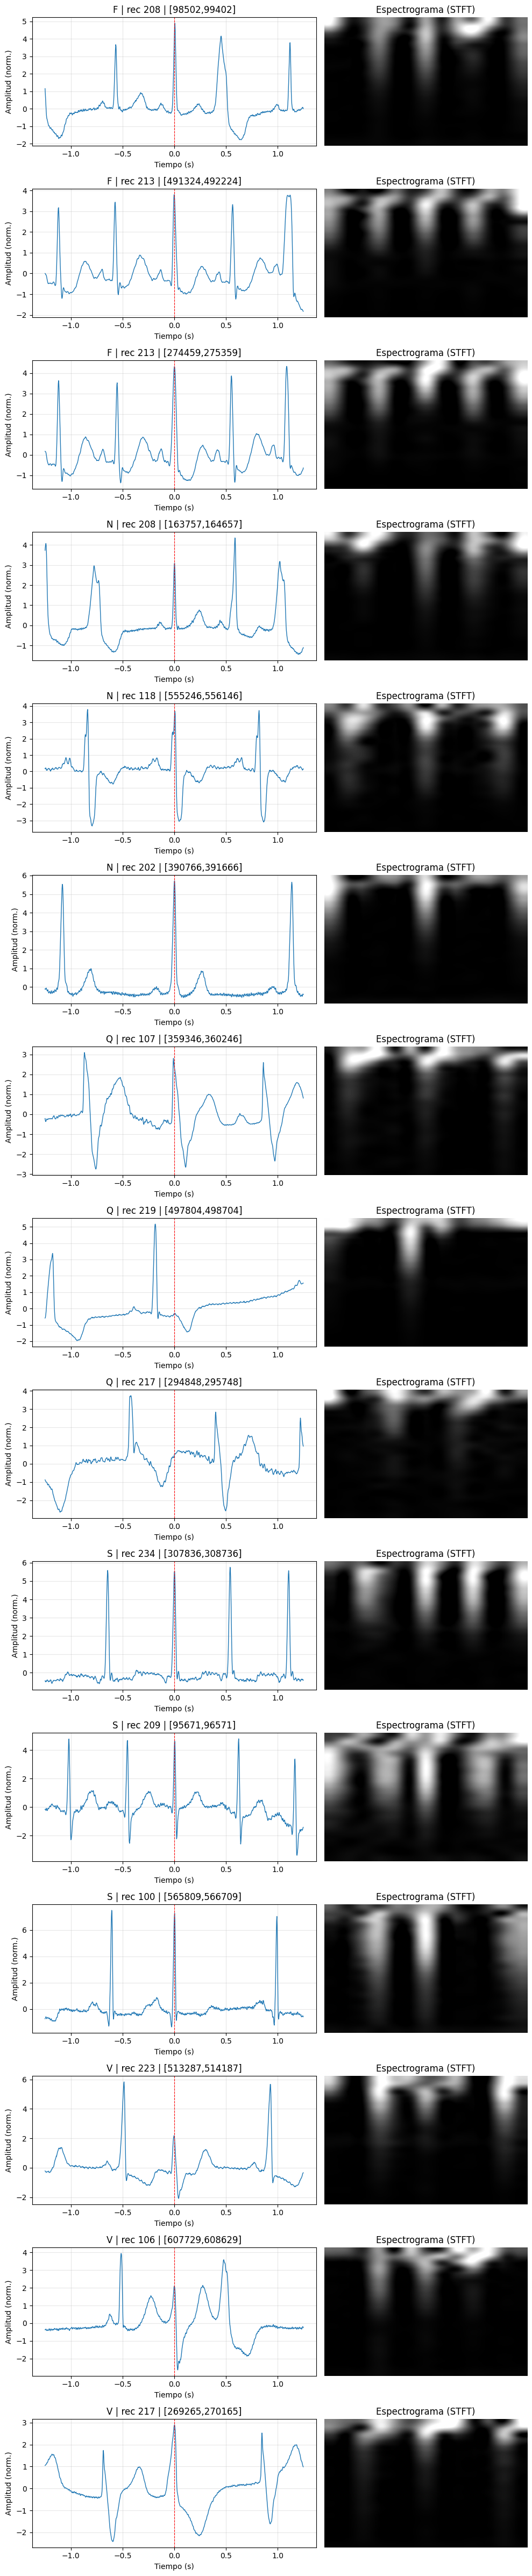

In [11]:
# ==== 2.3 Preview combinado: señal cruda + espectrograma ====
import matplotlib.pyplot as plt
import numpy as np

def _time_axis_for_window(sig_len: int, fs: int):
    """Eje de tiempo centrado en 0 (segundos)."""
    t = np.arange(sig_len) / fs
    return t - (sig_len / fs) / 2.0

def show_raw_and_spec(row, spec_cfg: SpecCfg, cmap="gray"):
    """Muestra (1) señal cruda de la ventana y (2) su espectrograma."""
    sig = row["signal"]; fs  = int(row["fs"])
    img = signal_to_spec_img(sig, fs, spec_cfg)
    t = _time_axis_for_window(len(sig), fs)

    fig, axes = plt.subplots(1, 2, figsize=(10, 3.2), gridspec_kw={"width_ratios":[1.4,1]})
    axes[0].plot(t, sig, linewidth=1.0)
    axes[0].axvline(0.0, color="r", linestyle="--", linewidth=0.8)  # centro ~ R-peak
    axes[0].set_title(f"ECG crudo | rec {row['record_id']} | {row['label']}")
    axes[0].set_xlabel("Tiempo (s)"); axes[0].set_ylabel("Amplitud (norm.)")
    axes[0].grid(True, alpha=0.3)

    axes[1].imshow(img, cmap=cmap, aspect="auto")
    axes[1].set_title("Espectrograma (STFT)"); axes[1].axis("off")

    plt.tight_layout(); plt.show()

def preview_raw_and_spec(df, per_class=3, spec_cfg: SpecCfg = SpecCfg(), seed=42, classes=None, cmap="gray"):
    """
    Muestra 'per_class' ejemplos por clase: señal cruda + espectrograma.
    """
    rng = np.random.default_rng(seed)
    classes = sorted(df["label"].unique()) if classes is None else list(classes)
    picked = []
    for c in classes:
        idxs = df.index[df["label"]==c].to_list()
        if not idxs: 
            continue
        rng.shuffle(idxs)
        picked.extend(idxs[:per_class])

    if not picked:
        print("No hay ejemplos para las clases solicitadas."); 
        return

    n = len(picked)
    fig, axes = plt.subplots(n, 2, figsize=(10, 3.2*n), squeeze=False, gridspec_kw={"width_ratios":[1.4,1]})
    for r, idx in enumerate(picked):
        row = df.loc[idx]
        sig = row["signal"]; fs = int(row["fs"])
        img = signal_to_spec_img(sig, fs, spec_cfg)
        t = _time_axis_for_window(len(sig), fs)

        ax0 = axes[r, 0]
        ax0.plot(t, sig, linewidth=1.0)
        ax0.axvline(0.0, color="r", linestyle="--", linewidth=0.8)
        ax0.set_title(f"{row['label']} | rec {row['record_id']} | [{row['start_idx']},{row['end_idx']}]")
        ax0.set_xlabel("Tiempo (s)"); ax0.set_ylabel("Amplitud (norm.)"); ax0.grid(True, alpha=0.3)

        ax1 = axes[r, 1]
        ax1.imshow(img, cmap=cmap, aspect="auto")
        ax1.set_title("Espectrograma (STFT)"); ax1.axis("off")

    plt.tight_layout(); plt.show()

# Config por defecto (ajustable)
spec_cfg = SpecCfg(
    nperseg=128, noverlap=64, nfft=None, window="hann",
    fmax=60.0, out_size=224, normalize="zscore_then_minmax",
    clip_percentiles=(1, 99)
)

# Un ejemplo puntual:
# show_raw_and_spec(df_windows.iloc[0], spec_cfg)

# Vista por clase (p.ej., 3 por clase):
preview_raw_and_spec(df_windows, per_class=3, spec_cfg=spec_cfg)


### 2.4.a Manifest CSV

Crea `outputs/manifest_windows.csv` con las columnas clave de cada ventana:

- `record_id`
- Índices (`start_idx`, `end_idx`)
- `fs`
- `label`
- `symbol`
- Índice original (`df_index`)

**Propósito**: trazabilidad y reproducibilidad del procesamiento.

---

### 2.4.b Caché legible de espectrogramas

- **`spec_cache_name(row, cfg)`**: Genera un nombre de archivo humano-legible para el `.npy` que codifica la ventana y los parámetros STFT (`nperseg`, `noverlap`, `fmax`, `out_size`).

- **`save_spec_cache(...)`**: Para cada fila, si no existe el par `.npy + .json`, calcula y guarda:
  - Imagen como `.npy` (matriz `uint8` 2D).
  - Metadatos como `.json` (incluye `ids`, índices, `fs`, `label`, `symbol`).

In [12]:
# ==== 2.4.a Manifest CSV para trazabilidad ====
import os, json, hashlib
import numpy as np
import pandas as pd

os.makedirs("outputs", exist_ok=True)

manifest_cols = ["record_id", "start_idx", "end_idx", "center_idx", "fs", "label", "symbol"]
df_manifest = (
    df_windows
    .reset_index()
    .rename(columns={"index": "df_index"})[["df_index"] + manifest_cols]
)

manifest_path = "outputs/manifest_windows.csv"
df_manifest.to_csv(manifest_path, index=False)
print("Manifest guardado en", manifest_path, "| filas:", len(df_manifest))

# ==== 2.4.b Cache legible de espectrogramas (nombres human-readable + JSON sidecar) ====
def _cfg_fingerprint(cfg: SpecCfg) -> str:
    """Hash corto para cambiar caché si cambian hiperparámetros relevantes."""
    payload = {
        "nperseg": cfg.nperseg, "noverlap": cfg.noverlap, "nfft": cfg.nfft,
        "window": cfg.window, "fmax": cfg.fmax, "out_size": cfg.out_size,
        "normalize": cfg.normalize, "clip": tuple(cfg.clip_percentiles)
    }
    return hashlib.sha1(json.dumps(payload, sort_keys=True).encode()).hexdigest()[:8]

def spec_cache_name(row: pd.Series, cfg: SpecCfg) -> str:
    fmax_str = "none" if cfg.fmax is None else str(int(cfg.fmax))
    return (
        f"{row['record_id']}"
        f"_c{int(row['center_idx'])}"
        f"_s{int(row['start_idx'])}"
        f"_e{int(row['end_idx'])}"
        f"_{row['label']}"
        f"_n{cfg.nperseg}_o{cfg.noverlap}_f{fmax_str}_sz{cfg.out_size}"
        f"_h{_cfg_fingerprint(cfg)}.npy"
    )

def save_spec_cache(df: pd.DataFrame, out_dir: str = "outputs/specs_cache",
                    spec_cfg: SpecCfg = SpecCfg(), max_items: int | None = None) -> None:
    os.makedirs(out_dir, exist_ok=True)
    it = df.iloc[:max_items] if max_items is not None else df
    saved = 0

    # Ordenar por record/center para nombres deterministas (útil para diffs)
    it = it.sort_values(["record_id", "center_idx"])

    for _, r in it.iterrows():
        fname = spec_cache_name(r, spec_cfg)
        npy_path = os.path.join(out_dir, fname)
        json_path = npy_path.replace(".npy", ".json")

        if os.path.exists(npy_path) and os.path.exists(json_path):
            continue

        img = signal_to_spec_img(r["signal"], int(r["fs"]), spec_cfg)  # (H,W) uint8 esperado
        # Seguridad: asegurar tipo
        if img.dtype != np.uint8:
            img = (np.clip(img, 0, 255)).astype(np.uint8)

        np.save(npy_path, img)
        meta = {
            "record_id": r["record_id"],
            "center_idx": int(r["center_idx"]),
            "start_idx": int(r["start_idx"]),
            "end_idx": int(r["end_idx"]),
            "fs": int(r["fs"]),
            "label": r["label"],
            "symbol": r["symbol"]
        }
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(meta, f, indent=2, ensure_ascii=False)

        saved += 1

    print(f"Cache guardado/actualizado en '{out_dir}'. Nuevos archivos: {saved}")

# Uso opcional:
# save_spec_cache(df_windows, out_dir="outputs/specs_cache", spec_cfg=spec_cfg, max_items=20000)

Manifest guardado en outputs/manifest_windows.csv | filas: 112647


In [13]:
# 1) conversión simple
ix = 0
img = signal_to_spec_img(df_windows.iloc[ix]["signal"], int(df_windows.iloc[ix]["fs"]), spec_cfg)
print("spec shape:", img.shape, "dtype:", img.dtype, "min/max:", img.min(), img.max())

# 2) dataset mínimo (sin DataLoader aún)
labels_sorted = sorted(df_windows["label"].unique())
label2idx = {l:i for i,l in enumerate(labels_sorted)}
ds_tmp = ECGSpecDataset(df_windows.sample(64, random_state=42), label2idx, spec_cfg, augment=False, return_meta=True)
x, y, meta = ds_tmp[0]
print("Tensor ejemplo:", x.shape, x.dtype, "label_id:", y.item(), "meta:", meta)

spec shape: (224, 224) dtype: uint8 min/max: 0 255
Tensor ejemplo: torch.Size([3, 224, 224]) torch.float32 label_id: 1 meta: {'i': 0, 'record_id': '222', 'center_idx': 363827, 'fs': 360, 'label': 'N', 'symbol': np.str_('N')}


# Seccion 3. Partición estratificada y agrupada (70/15/15)

### Objetivo: Split de `df_windows` en Train/Val/Test (70/15/15)

**Meta**: Dividir el dataset en proporciones 70% entrenamiento, 15% validación y 15% test, **estratificando por clase (`label`)** y **agrupando por `record_id`** para evitar fuga de datos entre particiones.

---

### Estrategia (heurística *greedy* en dos fases)

1. **Train (70%)**:
   - Selecciona grupos (`record_id`) para el conjunto de entrenamiento.
   - Criterio: maximizar la **similitud de la distribución por clase** con la distribución global.
   - El proceso intenta alcanzar aproximadamente el 70% del total de muestras.

2. **Val/Test (15%/15%)**:
   - De los grupos restantes, reparte entre Validación y Test en proporción 50/50.
   - Se mantiene la **distribución por clase** dentro de cada subconjunto.

In [14]:
import numpy as np
import pandas as pd

# ---------- 3.1: Utilidades de pesos/clases y métricas ----------
def _class_weights_from_global(total_cls: pd.Series, power: float = 1.0) -> pd.Series:
    """
    Pesos inversos a la frecuencia: clases raras (S, F) pesan más.
    power=1.0 => w_c = 1/p_c ; usa 0.5–1.0 para suavizar/fortalecer.
    """
    p = total_cls / max(total_cls.sum(), 1)
    w = 1.0 / (p + 1e-12)
    return (w / w.mean()) ** power

def _weighted_L1(sel_sum: pd.Series, target_ratio_vec: pd.Series, w: pd.Series) -> float:
    """Distancia L1 de distribuciones, ponderada por importancia de clase."""
    tot = sel_sum.sum()
    if tot <= 0:
        return np.inf
    p = sel_sum / tot
    err = (p - target_ratio_vec).abs().reindex(w.index, fill_value=0.0) * w
    return float(err.sum())

def _greedy_phase(groups, grp_cls, target_ratio, target_vec, total_all, tol, w):
    """
    Greedy por grupos: minimiza desvío de distribución + desvío de tamaño.
    No modifica la lógica de base; solo encapsula el scoring.
    """
    selected = set()
    current_sum = grp_cls.iloc[0:0].sum()  # Series ceros con mismas columnas
    for _ in range(len(groups)):
        best_g, best_score = None, np.inf
        for g in groups:
            if g in selected:
                continue
            cand_sum = current_sum + grp_cls.loc[g]
            prop_score = _weighted_L1(cand_sum, target_vec, w)
            size_ratio = cand_sum.sum() / max(total_all, 1)
            score = prop_score + abs(size_ratio - target_ratio)
            if score < best_score:
                best_g, best_score = g, score
        if best_g is None:
            break
        selected.add(best_g)
        current_sum = current_sum + grp_cls.loc[best_g]
        if current_sum.sum() >= target_ratio * total_all * (1 - tol):
            break
    return sorted(selected)

In [15]:
# ---------- 3.2: Split estratificado por clase y agrupado por record_id ----------
def stratified_group_split_weighted(
    df: pd.DataFrame,
    label_col: str = "label",
    group_col: str = "record_id",
    ratios=(0.7, 0.15, 0.15),
    tol: float = 0.02,
    seeds: int | list = 50,       # multi-start para estabilidad
    class_power: float = 1.2,     
    pin_train: list[str] | None = None,  #  record_ids fijos en TRAIN
    pin_val: list[str] | None = None,    # opcional: record_ids fijos en VAL
    pin_test: list[str] | None = None    # opcional: record_ids fijos en TEST
) -> dict[str, list[str]]:
    """
    Split por grupos sin leakage optimizando:
      - distribución por clase (ponderando más clases raras)
      - tamaño objetivo de cada parte (70/15/15)
    Se prueba con múltiples seeds y se devuelve el mejor split.
    Permite anclar registros concretos en train/val/test.
    """
    assert abs(sum(ratios) - 1.0) < 1e-6, "ratios debe sumar 1.0"
    if df.empty:
        return {"train": [], "val": [], "test": []}

    # Preparación
    pins_train = set([] if pin_train is None else [str(x) for x in pin_train])
    pins_val   = set([] if pin_val   is None else [str(x) for x in pin_val])
    pins_test  = set([] if pin_test  is None else [str(x) for x in pin_test])

    # Chequeo de intersección entre pines
    inter = (pins_train & pins_val) | (pins_train & pins_test) | (pins_val & pins_test)
    if inter:
        raise ValueError(f"Los siguientes record_id están anclados a más de un split: {sorted(inter)}")

    all_groups = df[group_col].astype(str).unique().tolist()
    grp_cls = df.groupby([group_col, label_col]).size().unstack(fill_value=0)
    total_cls = grp_cls.sum()
    total_all = int(total_cls.sum())
    if total_all == 0:
        return {"train": [], "val": [], "test": []}

    w = _class_weights_from_global(total_cls, power=class_power)

    # Semillas
    if isinstance(seeds, int):
        seeds = list(range(seeds))

    # Métrica global del split
    def _score_split(split) -> float:
        score = 0.0
        labels = total_cls.index
        target_vec_global = total_cls / total_all
        for part_name, target_ratio in zip(["train","val","test"], ratios):
            keys = split[part_name]
            if len(keys) == 0:
                return np.inf
            part_sum = grp_cls.loc[keys].sum()
            part_err = _weighted_L1(part_sum, target_vec_global, w)
            size_pen = abs(part_sum.sum()/total_all - target_ratio)
            score += part_err + size_pen
        return score

    best = (np.inf, None)

    # Conjuntos disponibles considerando pines
    fixed_all = pins_train | pins_val | pins_test
    free_groups = [g for g in all_groups if g not in fixed_all]

    # Sumas fijas por pin
    fixed_train_sum = grp_cls.loc[list(pins_train)].sum() if pins_train else grp_cls.iloc[0:0].sum()
    fixed_val_sum   = grp_cls.loc[list(pins_val)].sum()   if pins_val   else grp_cls.iloc[0:0].sum()
    fixed_test_sum  = grp_cls.loc[list(pins_test)].sum()  if pins_test  else grp_cls.iloc[0:0].sum()

    for sd in seeds:
        rng = np.random.default_rng(sd)
        groups = free_groups.copy()
        rng.shuffle(groups)

        # TRAIN
        tgt_vec = total_cls / total_all
        # Ajusta objetivo de tamaño restando lo que ya fijaste
        remain_total = total_all - (fixed_train_sum.sum() + fixed_val_sum.sum() + fixed_test_sum.sum())
        # Si todo quedó fijado, usa tal cual
        ratios_eff = ratios
        # Greedy sobre los libres para train:
        train_free = _greedy_phase(groups, grp_cls, ratios_eff[0], tgt_vec, total_all, tol, w)
        # Quita los elegidos para train
        rem_after_train = [g for g in groups if g not in train_free]

        # VAL (TEST = resto)
        if rem_after_train:
            rem_stats = grp_cls.loc[rem_after_train]
            rem_total2 = int(rem_stats.values.sum())
            if rem_total2 > 0:
                tgt_vec_rem = rem_stats.sum() / rem_total2
                val_free = _greedy_phase(rem_after_train, rem_stats, ratios_eff[1] / (ratios_eff[1] + ratios_eff[2] + 1e-12),
                                         tgt_vec_rem, rem_total2, tol, w)
            else:
                val_free = []
        else:
            val_free = []

        test_free = sorted([g for g in rem_after_train if g not in val_free])

        # Arma split con pines + libres
        split = {
            "train": sorted(list(pins_train)) + sorted(train_free),
            "val":   sorted(list(pins_val))   + sorted(val_free),
            "test":  sorted(list(pins_test))  + test_free
        }
        s = _score_split(split)
        if s < best[0]:
            best = (s, split)

    return best[1] if best[1] is not None else {"train": [], "val": [], "test": []}

In [16]:
# ---------- 3.3: Reparación opcional VAL <-> TEST (manteniendo TRAIN intacto) ----------
def repair_val_test_balance(df, class_power=1.2, max_iters=200, verbose=True):
    """
    Ajusta solo VAL<->TEST moviendo records completos para acercar conteos por clase a los objetivos 15/15.
    Mantiene TRAIN intacto.
    """
    ratios = {"train":0.70,"val":0.15,"test":0.15}
    df = df.copy()
    labels = sorted(df["label"].unique())

    tot_cls = df["label"].value_counts().reindex(labels, fill_value=0)
    target_counts = {sp: (tot_cls * r).round().astype(int) for sp, r in ratios.items()}

    freq = (tot_cls / tot_cls.sum()).clip(lower=1e-12)
    w = (1.0 / freq); w = (w / w.mean()) ** class_power

    def score(counts_val, counts_test):
        err = 0.0
        for sp, cnts in [("val", counts_val), ("test", counts_test)]:
            tgt = target_counts[sp].reindex(labels, fill_value=0)
            diff = (cnts.reindex(labels, fill_value=0) - tgt).abs()
            err += float((diff * w).sum())
            err += 0.25 * abs(cnts.sum() - tgt.sum())
        return err

    # IDs por split
    val_ids  = set(df.loc[df["split"]=="val","record_id"].astype(str).unique().tolist())
    test_ids = set(df.loc[df["split"]=="test","record_id"].astype(str).unique().tolist())

    # Conteos actuales por record
    per_rec = (df.groupby(["record_id","label"]).size()
               .unstack(fill_value=0)
               .reindex(columns=labels, fill_value=0))

    counts_val  = per_rec.loc[list(val_ids)].sum() if val_ids else per_rec.iloc[0:0].sum()
    counts_test = per_rec.loc[list(test_ids)].sum() if test_ids else per_rec.iloc[0:0].sum()
    best_score = score(counts_val, counts_test)

    if verbose:
        print(f"Score inicial: {best_score:.3f}")

    improved = True
    it = 0
    while improved and it < max_iters:
        improved = False
        it += 1

        best_local = (best_score, None, None)
        # TEST -> VAL
        for rid in list(test_ids):
            delta = per_rec.loc[rid]
            new_val, new_test = counts_val + delta, counts_test - delta
            s = score(new_val, new_test)
            if s < best_local[0]:
                best_local = (s, ("test", rid), "val")
        # VAL -> TEST
        for rid in list(val_ids):
            delta = per_rec.loc[rid]
            new_val, new_test = counts_val - delta, counts_test + delta
            s = score(new_val, new_test)
            if s < best_local[0]:
                best_local = (s, ("val", rid), "test")

        if best_local[1] is not None and best_local[0] + 1e-9 < best_score:
            origin, rid = best_local[1]
            if origin == "test":
                test_ids.remove(rid); val_ids.add(rid)
                counts_val  = counts_val  + per_rec.loc[rid]
                counts_test = counts_test - per_rec.loc[rid]
            else:
                val_ids.remove(rid); test_ids.add(rid)
                counts_val  = counts_val  - per_rec.loc[rid]
                counts_test = counts_test + per_rec.loc[rid]
            best_score = best_local[0]
            improved = True
            if verbose:
                print(f"[it {it}] move {rid} {origin}→{best_local[2]} | score={best_score:.3f}")

    # Construir asignaciones finales
    rec_to_split = {rid:"val" for rid in val_ids}
    rec_to_split.update({rid:"test" for rid in test_ids})
    fixed = df["split"].copy()
    mask = fixed.isin(["val","test"])
    fixed.loc[mask] = df.loc[mask, "record_id"].astype(str).map(rec_to_split)
    return fixed

In [17]:
# ---------- 3.4: Ejecutar split + reparar VAL/TEST ----------
PIN_TRAIN = []   # Ej.: ["232"]
PIN_VAL   = []
PIN_TEST  = []

split_groups = stratified_group_split_weighted(
    df_windows,
    label_col="label",
    group_col="record_id",
    ratios=(0.70, 0.15, 0.15),
    tol=0.02,
    seeds=50,
    class_power=1.2,
    pin_train=PIN_TRAIN,
    pin_val=PIN_VAL,
    pin_test=PIN_TEST
)

# Asignación por fila
record_to_split = {}
for part_name, recs in split_groups.items():
    for rid in recs:
        record_to_split[str(rid)] = part_name
df_windows["split"] = df_windows["record_id"].astype(str).map(record_to_split).fillna("")

In [18]:
# ---------- 3.5: Reportes y validaciones ----------
# 1) Sin leakage por record_id
leak = (df_windows.groupby("record_id")["split"].nunique().reset_index(name="n_parts"))
leaky = leak[leak["n_parts"] > 1]
assert leaky.empty, f"Leakage detectado en records: {leaky['record_id'].tolist()}"

# 2) Tamaños por partición
sizes = df_windows["split"].value_counts().to_dict()
print("Tamaños por split:", sizes)

# 3) Conteos por clase y split
by = (df_windows.groupby(["split","label"]).size()
      .unstack(fill_value=0)
      .reindex(index=["train","val","test"]))
print("\nConteos por clase:\n", by)

# 4) Proporciones por clase (fila=split)
props = (by / by.sum(axis=0)).round(3)
print("\nProporciones por clase (fila=split):\n", props)

# 5) Proporciones globales
global_props = (df_windows["split"].value_counts(normalize=True)
                .reindex(["train","val","test"])).round(3).to_dict()
print("\nProporciones globales:", global_props)

Tamaños por split: {'train': 78803, 'test': 16925, 'val': 16919}

Conteos por clase:
 label    F      N     Q     S     V
split                              
train  424  64064  8159  1364  4792
val    377  13925   750    20  1847
test     2  12642  2287  1397   597

Proporciones por clase (fila=split):
 label      F      N      Q      S      V
split                                   
train  0.528  0.707  0.729  0.490  0.662
val    0.469  0.154  0.067  0.007  0.255
test   0.002  0.139  0.204  0.502  0.083

Proporciones globales: {'train': 0.7, 'val': 0.15, 'test': 0.15}


In [19]:
# === Ajuste para 70/15/15 + listados de record_id por split ===
# 1) Anclar el outlier (S concentrado) a TRAIN y rehacer split
PIN_TRAIN = ["232"]   # <- anclamos 232 en train para evitar que S se vaya toda a test
PIN_VAL   = []
PIN_TEST  = []

split_groups = stratified_group_split_weighted(
    df_windows,
    label_col="label",
    group_col="record_id",
    ratios=(0.70, 0.15, 0.15),
    tol=0.02,
    seeds=50,
    class_power=1.2,
    pin_train=PIN_TRAIN,
    pin_val=PIN_VAL,
    pin_test=PIN_TEST
)

# Asignar split por fila
record_to_split = {}
for part_name, recs in split_groups.items():
    for rid in recs:
        record_to_split[str(rid)] = part_name
df_windows["split"] = df_windows["record_id"].astype(str).map(record_to_split).fillna("")

# 2) Reparar SOLO VAL <-> TEST (manteniendo TRAIN intacto) para acercar 15/15 por clase
df_windows["split"] = repair_val_test_balance(df_windows, class_power=1.2, max_iters=400, verbose=True)

# 3) Opcional: ajustar tamaños globales de VAL/TEST a ~15%/15% moviendo registros pequeños (sin empeorar clases)
"""
Nota: este ajuste NO busca balancear clases raras,
solo afinar tamaños globales val/test (~15%/15%).
Las clases raras se manejan mediante class_power > 1 y repair_val_test_balance.
"""
def fine_tune_val_test_sizes(df, target_ratio_val=0.15, target_ratio_test=0.15, max_steps=50):
    df = df.copy()
    total = len(df)
    target_val = int(round(total * target_ratio_val))
    target_test = int(round(total * target_ratio_test))

    # Conteo por record_id dentro de VAL/TEST
    per_rec = df.groupby(["record_id", "split"]).size().unstack(fill_value=0)
    val_ids = set(df.loc[df["split"]=="val","record_id"].astype(str).unique())
    test_ids = set(df.loc[df["split"]=="test","record_id"].astype(str).unique())

    cur_val = int(df["split"].eq("val").sum())
    cur_test = int(df["split"].eq("test").sum())

    # mover registros pequeños del que sobra al que falta
    steps = 0
    while steps < max_steps and (cur_val != target_val or cur_test != target_test):
        steps += 1
        # si val está grande, pasa un record pequeño de val->test; si test está grande, lo contrario
        if cur_val > target_val and val_ids:
            # candidato con menos filas en val
            cand = min(val_ids, key=lambda rid: per_rec.loc[rid, "val"] if "val" in per_rec.columns else 0)
            moved = int(per_rec.loc[cand, "val"])
            if moved == 0:
                val_ids.remove(cand); continue
            df.loc[df["record_id"].astype(str)==cand, "split"] = df.loc[df["record_id"].astype(str)==cand, "split"].replace("val","test")
            val_ids.remove(cand); test_ids.add(cand)
            cur_val -= moved; cur_test += moved
        elif cur_test > target_test and test_ids:
            cand = min(test_ids, key=lambda rid: per_rec.loc[rid, "test"] if "test" in per_rec.columns else 0)
            moved = int(per_rec.loc[cand, "test"])
            if moved == 0:
                test_ids.remove(cand); continue
            df.loc[df["record_id"].astype(str)==cand, "split"] = df.loc[df["record_id"].astype(str)==cand, "split"].replace("test","val")
            test_ids.remove(cand); val_ids.add(cand)
            cur_test -= moved; cur_val += moved
        else:
            break
    return df["split"]

# Ajuste fino de tamaños (si estás muy fuera del 15/15 global). Puedes comentar si ya te queda bien.
df_windows["split"] = fine_tune_val_test_sizes(df_windows, target_ratio_val=0.15, target_ratio_test=0.15, max_steps=30)

# 4) Reporte final y listados
sizes = df_windows["split"].value_counts(normalize=True).reindex(["train","val","test"]).round(3).to_dict()
print("Proporciones globales (esperado ~0.70/0.15/0.15):", sizes)

by = (df_windows.groupby(["split","label"]).size()
      .unstack(fill_value=0)
      .reindex(index=["train","val","test"]))
print("\nConteos por clase:\n", by)
print("\nProporciones por clase (fila=split):\n", (by / by.sum(axis=0)).round(3))

# Listar record_id por split
recs_train = sorted(df_windows.loc[df_windows["split"]=="train","record_id"].astype(str).unique())
recs_val   = sorted(df_windows.loc[df_windows["split"]=="val","record_id"].astype(str).unique())
recs_test  = sorted(df_windows.loc[df_windows["split"]=="test","record_id"].astype(str).unique())

print("\nRegistros en TRAIN (", len(recs_train), "):", recs_train)
print("Registros en VAL   (", len(recs_val),   "):", recs_val)
print("Registros en TEST  (", len(recs_test),  "):", recs_test)

Score inicial: 3527.456
[it 1] move 119 val→test | score=3430.866
[it 2] move 117 test→val | score=3279.734
Proporciones globales (esperado ~0.70/0.15/0.15): {'train': 0.716, 'val': 0.145, 'test': 0.139}

Conteos por clase:
 label    F      N     Q     S     V
split                              
train  424  64462  8195  2746  4792
val    377  13916   647    21  1403
test     2  12253  2354    14  1041

Proporciones por clase (fila=split):
 label      F      N      Q      S      V
split                                   
train  0.528  0.711  0.732  0.987  0.662
val    0.469  0.154  0.058  0.008  0.194
test   0.002  0.135  0.210  0.005  0.144

Registros en TRAIN ( 32 ): ['100', '102', '104', '105', '109', '112', '116', '118', '122', '124', '200', '201', '202', '203', '205', '207', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '230', '232', '233', '234']
Registros en VAL   ( 8 ): ['103', '111', '114', '117', '123', '208', '228', '231']
Registros en TE

**Configuración de partición final (Sección 3)**  
Split estratificado por clase (AAMI N/S/V/F/Q) y agrupado por `record_id`.  
Se fijó el registro 232 en TRAIN para preservar la representación de la clase S.  
Distribución final ≈ 70/15/15 sin leakage por registro.  
Listas de records fijas (TRAIN = 31, VAL = 8, TEST = 9).

# Seccion 4. Modelos (ResNet/MobileNet/EfficientNet)

In [20]:
# ============================================================
# Sección 4 — Label mappings, class weights y DataLoaders seguros (versión robusta)
# ============================================================

import math
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm

# ---------- 4.1: Label mapping y class weights ----------

def build_label_mappings(df, label_col="label"):
    """Deriva labels ordenados y mapeos (label2idx / idx2label)."""
    labels_sorted = sorted(df[label_col].astype(str).unique())
    label2idx = {l: i for i, l in enumerate(labels_sorted)}
    idx2label = {i: l for l, i in label2idx.items()}
    return labels_sorted, label2idx, idx2label


def compute_class_weights_from_train(df_train, labels_sorted, label_col="label"):
    """
    Calcula pesos inversos a la frecuencia sobre TRAIN.
    Normaliza para media ≈ 1 y blinda contra NaN/Inf/extremos.
    """
    vc = df_train[label_col].astype(str).value_counts()
    total = int(vc.sum())
    weights = []
    for lbl in labels_sorted:
        c = int(vc.get(lbl, 0))
        w = total / max(c, 1)
        weights.append(w)
    mean_w = sum(weights) / len(weights) if weights else 1.0
    weights = [w / mean_w for w in weights]
    class_weights = torch.tensor(weights, dtype=torch.float32)

    # Blindaje robusto
    class_weights = torch.nan_to_num(class_weights, nan=1.0, posinf=10.0, neginf=1.0)
    class_weights = torch.clamp(class_weights, min=1e-6, max=10.0)
    return class_weights


# ---------- 4.2: Crear datasets ----------

def make_datasets(df_windows, label2idx, spec_cfg,
                  aug_train=True, aug_val=False, aug_test=False,
                  return_meta=True):
    """Crea datasets para train/val/test usando ECGSpecDataset."""
    df_tr = df_windows[df_windows["split"] == "train"].reset_index(drop=True)
    df_va = df_windows[df_windows["split"] == "val"].reset_index(drop=True)
    df_te = df_windows[df_windows["split"] == "test"].reset_index(drop=True)

    ds_tr = ECGSpecDataset(df_tr, label2idx, spec_cfg,
                           augment=aug_train,
                           return_meta=return_meta,
                           cache_dir="./spec_cache_224/train")
    ds_va = ECGSpecDataset(df_va, label2idx, spec_cfg,
                           augment=aug_val,
                           return_meta=return_meta,
                           cache_dir="./spec_cache_224/val")
    ds_te = ECGSpecDataset(df_te, label2idx, spec_cfg,
                           augment=aug_test,
                           return_meta=return_meta,
                           cache_dir="./spec_cache_224/test")
    return ds_tr, ds_va, ds_te


# ---------- 4.3: DataLoaders seguros y optimizados (versión robusta) ----------

def make_dataloaders_safe(ds_tr, ds_va, ds_te,
                          batch_size=64, use_weighted_sampler=False):
    """
    Versión segura para evitar cuelgues en Windows u otros ambientes problemáticos.
    Usa num_workers=0 y persistent_workers=False para máxima compatibilidad.
    """
    is_windows = (os.name == "nt")
    is_cuda = torch.cuda.is_available()

    # Si es en Windows, mejor no usar multiprocessing en dataloader
    num_workers = 0 if is_windows else 4
    pin_memory = is_cuda and not is_windows
    persistent_workers = False

    sampler = None

    # # Optimización: calcular pesos directamente desde las etiquetas del DataFrame
    if use_weighted_sampler:
        print("Calculando pesos de muestreo balanceado (versión optimizada)...")
    labels_array = ds_tr.df["label"].map(ds_tr.label2idx).to_numpy()
    y_counts = Counter(labels_array)
    w_per_class = {cls: 1.0 / cnt for cls, cnt in y_counts.items()}
    example_weights = np.array([w_per_class[int(lbl)] for lbl in labels_array], dtype=np.float32)
    sampler = WeightedRandomSampler(example_weights,
                                    num_samples=len(example_weights),
                                    replacement=True)

    # if use_weighted_sampler:
    #     # calcular pesos por clase basados en el dataset de entrenamiento
    #     y_counts = Counter(int(ds_tr[i][1]) for i in range(len(ds_tr)))
    #     w_per_class = {cls: 1.0 / cnt for cls, cnt in y_counts.items()}
    #     example_weights = [w_per_class[int(ds_tr[i][1])] for i in range(len(ds_tr))]
    #     sampler = WeightedRandomSampler(example_weights,
    #                                     num_samples=len(example_weights),
    #                                     replacement=True)

    common = dict(
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        drop_last=False
    )

    dl_tr = DataLoader(ds_tr, sampler=sampler, shuffle=(sampler is None), **common)
    dl_va = DataLoader(ds_va, shuffle=False, **common)
    dl_te = DataLoader(ds_te, shuffle=False, **common)

    print(f" DataLoaders creados | num_workers={num_workers} | "
          f"persistent_workers={persistent_workers} | pin_memory={pin_memory}")
    return dl_tr, dl_va, dl_te


# ---------- 4.4: Construcción completa y verificación ----------

# Construir mapeos de etiquetas
labels_sorted, label2idx, idx2label = build_label_mappings(df_windows, label_col="label")
print("labels_sorted:", labels_sorted)
print("label2idx:", label2idx)

# Crear datasets
ds_train, ds_val, ds_test = make_datasets(
    df_windows, label2idx, spec_cfg,
    aug_train=True, aug_val=False, aug_test=False,
    return_meta=True
)

# Calcular pesos de clases (inversos a frecuencia en TRAIN)
#  Los pesos altos refuerzan el aprendizaje de clases raras (S y F),
#  evitando que la pérdida se vea dominada por la clase N.
#  Clamp evita explosiones numéricas o pérdida NaN.
class_weights = compute_class_weights_from_train(
    df_windows[df_windows["split"] == "train"],
    labels_sorted,
    label_col="label"
)
print("\n class_weights calculados (orden labels_sorted):", class_weights.tolist())

ratio = (class_weights.max() / class_weights.min()).item()
print(f"   ratio max/min: {ratio:.3f}")

# Mostrar relación entre pesos (útil para monitorear clases raras)
for lbl, w in zip(labels_sorted, class_weights.tolist()):
    print(f"  {lbl}: {w:.3f}")

if ratio > 20:
    print(" Pesos muy desbalanceados, aplicando clamp(min=0.1, max=10.0)...")
    class_weights = torch.clamp(class_weights.clone(), min=0.1, max=10.0)
    new_ratio = (class_weights.max() / class_weights.min()).item()
    print("→ class_weights corregidos:", class_weights.tolist())
    print(f"   nuevo ratio max/min: {new_ratio:.3f}")
else:
    print(" Pesos dentro de rango razonable.")

# Crear DataLoaders seguros
"""
Se activa WeightedRandomSampler para aumentar la frecuencia de ejemplos de las clases S y F durante el entrenamiento, 
sin alterar la distribución real del dataset
"""
dl_train, dl_val, dl_test = make_dataloaders_safe(
    ds_train, ds_val, ds_test,
    batch_size=64, use_weighted_sampler=True
)
print("\n Loaders seguros creados (num_workers ajustado automáticamente).")
print(f"Train batches: {math.ceil(len(ds_train) / 64)} | "
      f"Val: {math.ceil(len(ds_val) / 64)} | Test: {math.ceil(len(ds_test) / 64)}")

# Verificación estricta de batches (3 lotes)
num_classes = len(labels_sorted)
_checked = 0
for xb, yb, *_ in dl_train:
    if not torch.isfinite(xb).all():
        raise RuntimeError("Batch con NaN/Inf en X detectado.")
    if not torch.isfinite(yb.float()).all():
        raise RuntimeError("Batch con NaN/Inf en y detectado.")
    if xb.min() < 0 or xb.max() > 1:
        print("Aviso: rango de imágenes fuera de [0,1]. "
              "Considera aplicar torch.clamp dentro de tu Dataset.")
    if yb.dtype != torch.long:
        raise TypeError(f"Etiquetas con dtype {yb.dtype}, se requiere torch.long para CrossEntropyLoss.")
    if yb.min().item() < 0 or yb.max().item() >= num_classes:
        raise ValueError(f"Etiqueta fuera de rango [0,{num_classes-1}] detectada en el batch.")
    _checked += 1
    if _checked >= 3:
        break
print(" Verificación de 3 batches OK (datos finitos y etiquetas válidas).")


labels_sorted: [np.str_('F'), np.str_('N'), np.str_('Q'), np.str_('S'), np.str_('V')]
label2idx: {np.str_('F'): 0, np.str_('N'): 1, np.str_('Q'): 2, np.str_('S'): 3, np.str_('V'): 4}

 class_weights calculados (orden labels_sorted): [3.8425962924957275, 0.025274747982621193, 0.19881156086921692, 0.5933215022087097, 0.33999598026275635]
   ratio max/min: 152.033
  F: 3.843
  N: 0.025
  Q: 0.199
  S: 0.593
  V: 0.340
 Pesos muy desbalanceados, aplicando clamp(min=0.1, max=10.0)...
→ class_weights corregidos: [3.8425962924957275, 0.10000000149011612, 0.19881156086921692, 0.5933215022087097, 0.33999598026275635]
   nuevo ratio max/min: 38.426
Calculando pesos de muestreo balanceado (versión optimizada)...
 DataLoaders creados | num_workers=0 | persistent_workers=False | pin_memory=False

 Loaders seguros creados (num_workers ajustado automáticamente).
Train batches: 1260 | Val: 256 | Test: 245
 Verificación de 3 batches OK (datos finitos y etiquetas válidas).


In [21]:
# # ============================================================
# # 4.5 Construcción de caché de espectrogramas (solo una vez)
# # ============================================================

# CACHE_ROOT = Path("./spec_cache_224")
# CACHE_ROOT.mkdir(parents=True, exist_ok=True)

# def build_spec_cache(df_split, split_name, func_signal_to_img):
#     """Genera y guarda los espectrogramas en ./spec_cache_224/{split_name}."""
#     outdir = CACHE_ROOT / split_name
#     outdir.mkdir(parents=True, exist_ok=True)
#     print(f"→ Construyendo caché para '{split_name}' en {outdir}")
#     for i, row in tqdm(df_split.reset_index(drop=True).iterrows(), total=len(df_split)):
#         row_id = row.get("row_id", f"{row['record_id']}_{int(row['center_idx'])}_{i}")
#         p = outdir / f"{row_id}.png"
#         if p.exists():
#             continue
#         img = func_signal_to_img(row["signal"], row["fs"])
#         cv2.imwrite(str(p), img)
#     print(f"Caché '{split_name}' lista: {len(list(outdir.glob('*.png')))} archivos.\n")

# # Ejecuta esta celda solo la primera vez
# build_spec_cache(df_windows[df_windows["split"]=="train"], "train", signal_to_spec_img)
# build_spec_cache(df_windows[df_windows["split"]=="val"],   "val",   signal_to_spec_img)
# build_spec_cache(df_windows[df_windows["split"]=="test"],  "test",  signal_to_spec_img)

In [22]:
# ============================================================
# 4.6 Factoría de modelos (ResNet50 / MobileNetV3-Large / EfficientNetV2-B0)
# ============================================================

import torch
import torch.nn as nn
import torchvision.models as tvm

def _set_classifier_out(in_features: int, num_classes: int) -> nn.Linear:
    """Devuelve una capa lineal para el clasificador final."""
    layer = nn.Linear(in_features, num_classes)
    nn.init.xavier_uniform_(layer.weight)
    nn.init.zeros_(layer.bias)
    return layer


def build_model(arch: str, num_classes: int = 5, pretrained: bool = True) -> nn.Module:
    """Crea un modelo con pesos preentrenados y adapta el clasificador final."""
    arch = arch.lower()

    # ---------- ResNet-50 ----------
    if arch == "resnet50":
        try:
            weights = tvm.ResNet50_Weights.DEFAULT if pretrained else None
            model = tvm.resnet50(weights=weights)
        except Exception:
            model = tvm.resnet50(pretrained=pretrained)
        in_f = model.fc.in_features
        model.fc = _set_classifier_out(in_f, num_classes)
        return model

    # ---------- MobileNet V3-Large ----------
    if arch in ["mobilenet_v3_large", "mobilenetv3-large", "mobilenetv3_large"]:
        try:
            weights = tvm.MobileNet_V3_Large_Weights.DEFAULT if pretrained else None
            model = tvm.mobilenet_v3_large(weights=weights)
        except Exception:
            model = tvm.mobilenet_v3_large(pretrained=pretrained)
        in_f = model.classifier[-1].in_features
        model.classifier[-1] = _set_classifier_out(in_f, num_classes)
        return model

    # ---------- EfficientNet V2-B0 ----------
    if arch in ["efficientnetv2_b0", "efficientnet-v2-b0", "efficientnet_v2_b0"]:
        try:
            import timm
            model = timm.create_model("efficientnetv2_b0", pretrained=pretrained, num_classes=num_classes)
            return model
        except Exception:
            try:
                weights = tvm.EfficientNet_B0_Weights.DEFAULT if pretrained else None
                model = tvm.efficientnet_b0(weights=weights)
            except Exception:
                model = tvm.efficientnet_b0(pretrained=pretrained)
            in_f = model.classifier[-1].in_features
            model.classifier[-1] = _set_classifier_out(in_f, num_classes)
            return model

    raise ValueError(f"Arquitectura no soportada: {arch}")


# ---------- Inicialización del dispositivo ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# Seccion 5. Entrenamiento y tuning

In [23]:
# ============================================================
# Sección 5 — Entrenamiento y Evaluación robusta (sin NaN)
# ============================================================
import os, gc, time, copy, math
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch import amp
from sklearn.metrics import f1_score, accuracy_score, classification_report
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# ---------- 5.1 Funciones auxiliares ----------
def compute_metrics(y_true, y_pred, labels_sorted):
    """Devuelve macro-F1 y métricas por clase."""
    f1_macro = f1_score(y_true, y_pred, average="macro")
    report = classification_report(y_true, y_pred, target_names=labels_sorted,
                                   output_dict=True, zero_division=0)
    return f1_macro, report


def evaluate_model(model, dl, device, labels_sorted, criterion=None):
    """Evalúa el modelo en un DataLoader (sin grad)."""
    model.eval()
    preds, trues, losses = [], [], []
    with torch.no_grad():
        for xb, yb, *_ in dl:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            logits = model(xb)
            if criterion is not None:
                loss = criterion(logits, yb)
                losses.append(loss.item())
            preds.append(logits.argmax(1).cpu())
            trues.append(yb.cpu())
    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()
    f1_macro, report = compute_metrics(trues, preds, labels_sorted)
    mean_loss = np.mean(losses) if losses else None
    return f1_macro, report, mean_loss


# ---------- 5.2 Entrenamiento estable (anti-NaN, AMP opcional) ----------
def train_model_pretty(
    arch="resnet50",
    num_epochs=10,
    lr=3e-4,
    weight_decay=1e-4,
    max_grad_norm=2.0,
    use_onecycle=True,
    dl_train=None, dl_val=None, dl_test=None,
    class_weights_tensor=None,
    labels_sorted=None,
    device=None,
    ckpt_dir="./checkpoints"
):
    os.makedirs(ckpt_dir, exist_ok=True)

    # --- Modelo ---
    model = build_model(arch, num_classes=len(labels_sorted), pretrained=True).to(device)

    # --- Criterio y pesos ---
    cw = class_weights_tensor.to(device, dtype=torch.float32)
    cw = torch.nan_to_num(cw, nan=1.0, posinf=10.0, neginf=1.0)
    cw = torch.clamp(cw, min=1e-6, max=10.0)
    criterion = nn.CrossEntropyLoss(weight=cw)

    # --- Optimizador / scheduler ---
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = None
    if use_onecycle:
        steps_per_epoch = len(dl_train)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=steps_per_epoch
        )

    # --- AMP: empieza desactivado hasta tener estabilidad ---
    scaler = amp.GradScaler(enabled=False)  # puedes cambiar a True cuando el loss sea estable

    best_f1, best_state = -1.0, None
    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    print(f"\nEntrenando {arch.upper()} con {len(labels_sorted)} clases...")
    start = time.time()

    try:
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            preds, trues = [], []

            pbar = tqdm(dl_train, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
            for xb, yb, *_ in pbar:
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)

                # --- Forward con autocast (AMP desactivado inicialmente) ---
                with torch.amp.autocast("cuda", enabled=scaler.is_enabled()):
                    logits = model(xb)
                    loss = criterion(logits, yb)

                # --- Chequeo de NaN antes del backward ---
                if not torch.isfinite(loss):
                    print(" Loss no finita detectada. Debug:")
                    print("  logits finite:", torch.isfinite(logits).all().item(),
                          "min/max:", logits.min().item(), logits.max().item())
                    print("  yb min/max:", yb.min().item(), yb.max().item())
                    print("  class_weights:", cw.detach().cpu().tolist())
                    raise RuntimeError("Loss NaN/Inf — aborta para proteger pesos.")

                # --- Backward ---
                scaler.scale(loss).backward()
                total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                if not math.isfinite(total_norm):
                    raise RuntimeError(f"Grad norm no finita: {total_norm}")

                scaler.step(optimizer)
                scaler.update()
                if scheduler: scheduler.step()

                running_loss += loss.item()
                preds.append(logits.argmax(1).detach().cpu())
                trues.append(yb.detach().cpu())

                pbar.set_postfix(loss=f"{running_loss/bi:.4f}" if 'bi' in locals() else f"{loss.item():.4f}")

            # --- Métricas de entrenamiento ---
            preds = torch.cat(preds).numpy()
            trues = torch.cat(trues).numpy()
            train_acc = (preds == trues).mean()
            mean_loss = running_loss / max(1, len(dl_train))

            # --- Validación ---
            val_f1, _, val_loss = evaluate_model(model, dl_val, device, labels_sorted, criterion)

            # --- Registro ---
            history["train_loss"].append(mean_loss)
            history["val_loss"].append(val_loss)
            history["val_f1"].append(val_f1)

            lr_now = scheduler.get_last_lr()[0] if scheduler else lr
            dt = time.time() - start

            print(f"Epoch {epoch+1}/{num_epochs} ━ {dt:.0f}s "
                  f"- loss: {mean_loss:.4f} - acc: {train_acc:.4f} "
                  f"- val_loss: {val_loss:.4f} - val_f1: {val_f1:.4f} - lr: {lr_now:.2e}")

            # --- Checkpoint ---
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_state = copy.deepcopy(model.state_dict())
                torch.save(best_state, os.path.join(ckpt_dir, f"{arch}_best.pt"))
                print(f"  Nuevo mejor modelo guardado (F1={best_f1:.4f})")

        print(f"\n Entrenamiento finalizado en {time.time()-start:.1f}s")

    except KeyboardInterrupt:
        torch.save(model.state_dict(), os.path.join(ckpt_dir, f"{arch}_INTERRUPTED.pt"))
        print("\n Entrenamiento interrumpido. Checkpoint guardado.")
    finally:
        if best_state is not None:
            model.load_state_dict(best_state)
        torch.cuda.empty_cache()
        gc.collect()

    # ---------- Evaluación final ----------
    print("\nEvaluando modelo final en VALIDATION y TEST ...")
    val_f1, val_report, _ = evaluate_model(model, dl_val, device, labels_sorted, criterion)
    test_f1, test_report, _ = evaluate_model(model, dl_test, device, labels_sorted, criterion)
    print(f"Macro-F1 Val={val_f1:.4f} | Test={test_f1:.4f}")
    return model, history, val_report, test_report

In [24]:
# # ============================================================
# # 5.4-A — Entrenamiento estable de MobileNet V3-Large
# # ============================================================

# import matplotlib.pyplot as plt
# import torch
# import os

# arch_choice = "mobilenet_v3_large"

# try:
#     # --- Entrenamiento principal ---
#     model_mnet, hist_mnet, val_report, test_report = train_model_pretty(
#         arch=arch_choice,
#         num_epochs=15,
#         lr=3e-4,
#         weight_decay=1e-4,
#         max_grad_norm=2.0,
#         use_onecycle=True,
#         dl_train=dl_train,
#         dl_val=dl_val,
#         dl_test=dl_test,          # incluye test
#         class_weights_tensor=class_weights,
#         labels_sorted=labels_sorted,
#         device=device,
#     )

# except KeyboardInterrupt:
#     # --- Interrupción segura (Ctrl+C) ---
#     print("\n Entrenamiento interrumpido manualmente. Guardando checkpoint temporal...")
#     os.makedirs("saved_models", exist_ok=True)
#     ckpt_path = os.path.join("saved_models", f"{arch_choice}_interrupt.pt")
#     torch.save(model_mnet.state_dict(), ckpt_path)
#     print(f"Checkpoint guardado en: {ckpt_path}")
#     raise  # vuelve a lanzar la excepción para detener la ejecución del resto de celdas

# # ---------- Visualización ----------
# plt.figure(figsize=(8, 4))
# plt.plot(hist_mnet["train_loss"], label="Train Loss", marker="o")
# plt.plot(hist_mnet["val_loss"], label="Val Loss", marker="o")
# plt.plot(hist_mnet["val_f1"], label="Val F1 (macro)", marker="s")
# plt.xlabel("Epoch")
# plt.ylabel("Valor")
# plt.title("Evolución — MobileNet V3-Large (Entrenamiento y Validación)")
# plt.grid(True, linestyle="--", alpha=0.6)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ---------- Resumen de métricas finales ----------
# print("\n Métricas finales:")
# print(f"  Último Train Loss: {hist_mnet['train_loss'][-1]:.4f}")
# print(f"  Último Val Loss:   {hist_mnet['val_loss'][-1]:.4f}")
# print(f"  Último Val F1:     {hist_mnet['val_f1'][-1]:.4f}")

# 6. — Análisis de Sensibilidad de Hiperparámetros (MobileNetV3-Large)


=== INICIANDO ANÁLISIS DE SENSIBILIDAD RÁPIDO ===

[TEST] lr = 0.0001

Entrenando MOBILENET_V3_LARGE con 5 clases...


Epoch 1/1:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1/1 ━ 579s - loss: 0.4406 - acc: 0.8382 - val_loss: 0.3442 - val_f1: 0.4869 - lr: 7.17e-10
  Nuevo mejor modelo guardado (F1=0.4869)

 Entrenamiento finalizado en 579.2s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.4869 | Test=0.5623
  -> F1_val=0.4869 (815.2s)

[TEST] lr = 0.0003

Entrenando MOBILENET_V3_LARGE con 5 clases...


Epoch 1/1:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1/1 ━ 547s - loss: 0.3093 - acc: 0.8873 - val_loss: 0.2451 - val_f1: 0.5663 - lr: 2.15e-09
  Nuevo mejor modelo guardado (F1=0.5663)

 Entrenamiento finalizado en 546.9s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.5663 | Test=0.6164
  -> F1_val=0.5663 (650.4s)

[TEST] lr = 0.001

Entrenando MOBILENET_V3_LARGE con 5 clases...


Epoch 1/1:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1/1 ━ 534s - loss: 0.2505 - acc: 0.9115 - val_loss: 0.4646 - val_f1: 0.5080 - lr: 7.17e-09
  Nuevo mejor modelo guardado (F1=0.5080)

 Entrenamiento finalizado en 534.0s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.5080 | Test=0.5977
  -> F1_val=0.5080 (638.0s)

[TEST] batch_size = 32

Entrenando MOBILENET_V3_LARGE con 5 clases...


Epoch 1/1:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1/1 ━ 525s - loss: 0.3144 - acc: 0.8863 - val_loss: 0.2870 - val_f1: 0.4996 - lr: 2.15e-09
  Nuevo mejor modelo guardado (F1=0.4996)

 Entrenamiento finalizado en 525.4s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.4996 | Test=0.5772
  -> F1_val=0.4996 (629.4s)

[TEST] batch_size = 64

Entrenando MOBILENET_V3_LARGE con 5 clases...


Epoch 1/1:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1/1 ━ 554s - loss: 0.3125 - acc: 0.8868 - val_loss: 0.3215 - val_f1: 0.4962 - lr: 2.15e-09
  Nuevo mejor modelo guardado (F1=0.4962)

 Entrenamiento finalizado en 553.8s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.4962 | Test=0.5994
  -> F1_val=0.4962 (659.7s)

[TEST] dropout_rate = 0.0

Entrenando MOBILENET_V3_LARGE con 5 clases...


Epoch 1/1:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1/1 ━ 546s - loss: 0.3111 - acc: 0.8855 - val_loss: 0.3488 - val_f1: 0.4744 - lr: 2.15e-09
  Nuevo mejor modelo guardado (F1=0.4744)

 Entrenamiento finalizado en 546.3s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.4744 | Test=0.5587
  -> F1_val=0.4744 (650.1s)

[TEST] dropout_rate = 0.2

Entrenando MOBILENET_V3_LARGE con 5 clases...


Epoch 1/1:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1/1 ━ 541s - loss: 0.3082 - acc: 0.8877 - val_loss: 0.4586 - val_f1: 0.5155 - lr: 2.15e-09
  Nuevo mejor modelo guardado (F1=0.5155)

 Entrenamiento finalizado en 541.2s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.5155 | Test=0.6067
  -> F1_val=0.5155 (644.2s)

[TEST] dropout_rate = 0.4

Entrenando MOBILENET_V3_LARGE con 5 clases...


Epoch 1/1:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1/1 ━ 520s - loss: 0.3074 - acc: 0.8869 - val_loss: 0.4617 - val_f1: 0.4577 - lr: 2.15e-09
  Nuevo mejor modelo guardado (F1=0.4577)

 Entrenamiento finalizado en 520.0s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.4577 | Test=0.6046
  -> F1_val=0.4577 (626.6s)

[TEST] optimizer = adam

Entrenando MOBILENET_V3_LARGE con 5 clases...


Epoch 1/1:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1/1 ━ 552s - loss: 0.3151 - acc: 0.8862 - val_loss: 0.2795 - val_f1: 0.5244 - lr: 2.15e-09
  Nuevo mejor modelo guardado (F1=0.5244)

 Entrenamiento finalizado en 552.3s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.5244 | Test=0.6106
  -> F1_val=0.5244 (658.5s)

[TEST] optimizer = sgd

Entrenando MOBILENET_V3_LARGE con 5 clases...


Epoch 1/1:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch 1/1 ━ 517s - loss: 0.3137 - acc: 0.8836 - val_loss: 0.4356 - val_f1: 0.4749 - lr: 2.15e-09
  Nuevo mejor modelo guardado (F1=0.4749)

 Entrenamiento finalizado en 517.3s

Evaluando modelo final en VALIDATION y TEST ...
Macro-F1 Val=0.4749 | Test=0.5967
  -> F1_val=0.4749 (622.1s)

F1 baseline aproximado: 0.5256


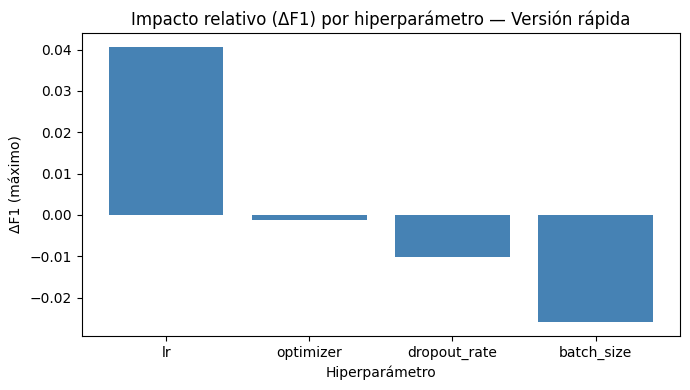

,hp,delta_f1_vs_base
2,lr,0.040706
3,optimizer,-0.001188
1,dropout_rate,-0.010105
0,batch_size,-0.025940


In [27]:
# ============================================================
# 6. — Análisis de Sensibilidad de Hiperparámetros (MobileNetV3-Large)
# ============================================================
# Requisitos previos:
# - Haber ejecutado la Sección 4 (DataLoaders) y la Sección 5 (train_model_pretty estable con AMP/EMA).
# - Variables disponibles: dl_train, dl_val, dl_test, device, labels_sorted
# - Función disponible: train_model_pretty(arch=..., num_epochs=..., lr=..., weight_decay=..., ...)

import time
import copy
from typing import Dict, Any, List, Tuple
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

torch.backends.cudnn.benchmark = True

# ------------------------------------------------------------
# 6.1 — Utilidades
# ------------------------------------------------------------

def build_mobilenet_head(
    num_features: int,
    num_classes: int,
    dropout_rate: float = 0.2,
    num_hidden_layers: int = 1,
    hidden_units: int = 512
) -> nn.Sequential:
    layers: List[nn.Module] = [nn.Flatten()]
    in_dim = num_features
    for _ in range(max(0, num_hidden_layers)):
        layers += [nn.Linear(in_dim, hidden_units), nn.Hardswish(), nn.Dropout(p=dropout_rate)]
        in_dim = hidden_units
    layers += [nn.Linear(in_dim, num_classes)]
    return nn.Sequential(*layers)


def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_macro_f1_from_report(report_dict: Dict[str, Any]) -> float:
    try:
        return float(report_dict["macro avg"]["f1-score"])
    except Exception:
        return float("nan")


# ------------------------------------------------------------
# 6.2 — Runner de un experimento con proxy de épocas (versión compatible)
# ------------------------------------------------------------

def run_experiment_cfg(
    cfg: Dict[str, Any],
    dl_train_base: DataLoader,
    dl_val_base: DataLoader,
    labels_sorted: List[str],
    device: torch.device,
    epochs_proxy: int = 3,
    weight_decay: float = 1e-4
) -> Dict[str, Any]:
    """
    Ejecuta un entrenamiento corto (proxy) para medir F1 macro en validación.
    Totalmente compatible con train_model_pretty() actual.
    """
    from torchvision import models

    num_classes = len(labels_sorted)

    # --- Construcción del modelo con cabeza modificada ---
    base_model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
    num_features = base_model.classifier[-1].in_features
    base_model.classifier = build_mobilenet_head(
        num_features=num_features,
        num_classes=num_classes,
        dropout_rate=cfg["dropout_rate"],
        num_hidden_layers=cfg["num_hidden_layers"],
        hidden_units=cfg["hidden_units"]
    )
    model = base_model.to(device)

    # Exponer el modelo globalmente (por compatibilidad con tu función)
    globals()["model"] = model

    # Crear tensor de pesos uniforme para evitar AttributeError
    class_weights_tensor = torch.ones(len(labels_sorted))

    # Entrenamiento corto (proxy)
    start = time.time()
    model_out, hist, val_report, test_report = train_model_pretty(
        arch="mobilenet_v3_large",
        num_epochs=epochs_proxy,
        lr=cfg["lr"],
        weight_decay=weight_decay,
        labels_sorted=labels_sorted,
        device=device,
        class_weights_tensor=class_weights_tensor,
        dl_train=dl_train,
        dl_val=dl_val,
        dl_test=dl_test
    )

    elapsed = time.time() - start

    f1_macro = get_macro_f1_from_report(val_report)

    return {
        "f1_macro_val": f1_macro,
        "time_sec": elapsed,
        "params": count_params(model),
        "optimizer_used": cfg["optimizer"]
    }


# ============================================================
# 6.X — Análisis de Sensibilidad (versión rápida para informe)
# ============================================================

# Solo 4 hiperparámetros y 1 época por configuración (≈3-4 min por corrida)
EPOCHS_PROXY = 1  

SPACE_OAT = {
    "lr": [1e-4, 3e-4, 1e-3],
    "batch_size": [32, 64],
    "dropout_rate": [0.0, 0.2, 0.4],
    "optimizer": ["adam", "sgd"]
}

# Redefinimos baseline simple
BASELINE = {
    "lr": 3e-4,
    "batch_size": 64,
    "dropout_rate": 0.2,
    "num_hidden_layers": 1,
    "hidden_units": 512,
    "optimizer": "adam"
}

def sweep_oat_fast(
    baseline: Dict[str, Any],
    space_oat: Dict[str, List[Any]],
    epochs_proxy: int = 1
) -> pd.DataFrame:
    records = []
    print("\n=== INICIANDO ANÁLISIS DE SENSIBILIDAD RÁPIDO ===")
    for hp_name, candidates in space_oat.items():
        for val in candidates:
            cfg = copy.deepcopy(baseline)
            cfg[hp_name] = val
            print(f"\n[TEST] {hp_name} = {val}")
            try:
                res = run_experiment_cfg(cfg, dl_train, dl_val, labels_sorted, device, epochs_proxy=epochs_proxy)
                records.append({
                    "phase": "OAT",
                    "hp": hp_name,
                    **cfg,
                    **res
                })
                print(f"  -> F1_val={res['f1_macro_val']:.4f} ({res['time_sec']:.1f}s)")
            except Exception as e:
                print(f"  Error en {hp_name}={val}: {e}")
    return pd.DataFrame.from_records(records)

df_oat = sweep_oat_fast(BASELINE, SPACE_OAT, epochs_proxy=EPOCHS_PROXY)

# Calcular baseline rápido
F1_BASELINE = df_oat.loc[
    (df_oat["lr"] == BASELINE["lr"]) &
    (df_oat["batch_size"] == BASELINE["batch_size"]) &
    (df_oat["dropout_rate"] == BASELINE["dropout_rate"]) &
    (df_oat["optimizer"] == BASELINE["optimizer"]),
    "f1_macro_val"
].mean()

print(f"\nF1 baseline aproximado: {F1_BASELINE:.4f}")

# Agregar delta F1
df_oat["delta_f1_vs_base"] = df_oat["f1_macro_val"] - F1_BASELINE

# Visualización
oat_summary = (
    df_oat.groupby("hp", as_index=False)["delta_f1_vs_base"]
    .max()
    .sort_values("delta_f1_vs_base", ascending=False)
)

plt.figure(figsize=(7, 4))
plt.bar(oat_summary["hp"], oat_summary["delta_f1_vs_base"], color="steelblue")
plt.title("Impacto relativo (ΔF1) por hiperparámetro — Versión rápida")
plt.xlabel("Hiperparámetro")
plt.ylabel("ΔF1 (máximo)")
plt.tight_layout()
plt.show()

display(oat_summary)


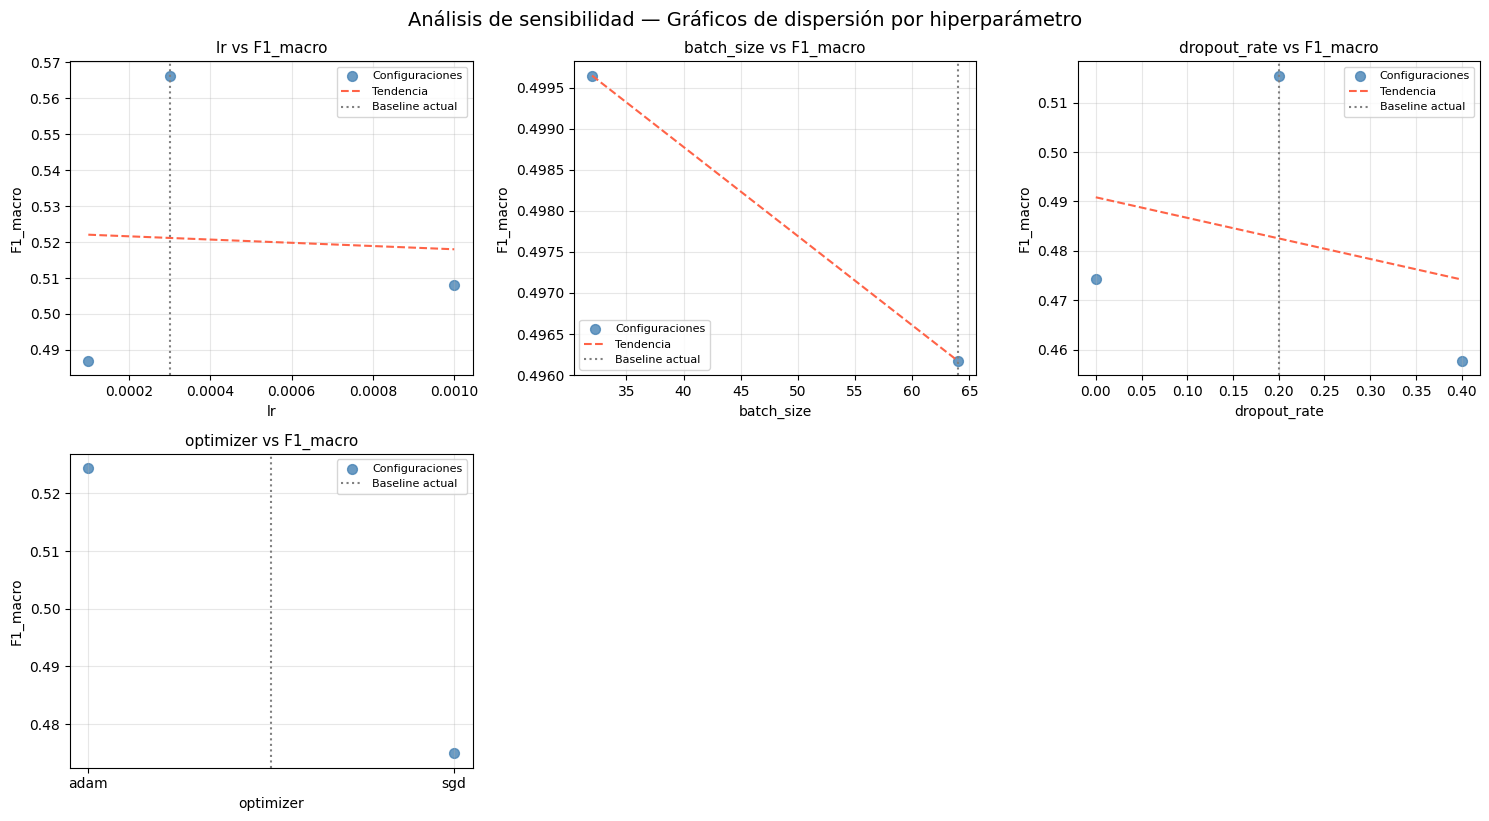

Gráficas guardadas en: analisis_sensibilidad_dispersion.png (alta resolución)


In [32]:
# ============================================================
# 6.6 — Gráficas de dispersión por hiperparámetro (desde df_oat)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

assert "df_oat" in globals(), "df_oat no está definido; ejecuta primero el análisis OAT."

# Lista de hiperparámetros a graficar (solo los presentes en SPACE_OAT)
hp_list = list(SPACE_OAT.keys())

# Crear figura
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, hp in enumerate(hp_list):
    ax = axes[i]

    # Filtrar datos de este hiperparámetro
    df_hp = df_oat[df_oat["hp"] == hp]

    # Obtener valores x (hiperparámetro) y y (score)
    x = df_hp[hp].values
    y = df_hp["f1_macro_val"].values

    # Dispersión
    ax.scatter(x, y, color="steelblue", s=50, alpha=0.8, label="Configuraciones")

    # Línea de tendencia (solo si hay >=2 puntos numéricos)
    if np.issubdtype(np.array(x).dtype, np.number) and len(np.unique(x)) > 1:
        coeffs = np.polyfit(x, y, deg=1)
        trend = np.polyval(coeffs, np.linspace(min(x), max(x), 100))
        ax.plot(np.linspace(min(x), max(x), 100), trend, color="tomato", linestyle="--", linewidth=1.5, label="Tendencia")

    # Línea vertical para el baseline
    baseline_val = BASELINE[hp]
    if isinstance(baseline_val, (int, float)):
        ax.axvline(x=baseline_val, color="gray", linestyle=":", linewidth=1.5, label="Baseline actual")
    else:
        # Para optimizador (categoría)
        ax.axvline(x=0.5, color="gray", linestyle=":", linewidth=1.5, label="Baseline actual")

    ax.set_title(f"{hp} vs F1_macro", fontsize=11)
    ax.set_xlabel(hp)
    ax.set_ylabel("F1_macro")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

# Ocultar ejes vacíos si hay menos de 6 gráficos
for j in range(len(hp_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Análisis de sensibilidad — Gráficos de dispersión por hiperparámetro", fontsize=14, y=1.02)
plt.savefig("analisis_sensibilidad_dispersion.png", dpi=300, bbox_inches="tight")
plt.show()

print("Gráficas guardadas en: analisis_sensibilidad_dispersion.png (alta resolución)")


# Análisis de Sensibilidad — *MobileNetV3-Large*

## 1. Learning Rate (`lr`)
- **Rango probado:** 1e-4 → 3e-4 → 1e-3  
- **F1 macro validación:** 0.4869 → 0.5663 → 0.5080  
- **Tendencia:** relación no lineal con máximo intermedio.  
- **Conclusión:** existe un punto óptimo alrededor de **3e-4**, donde se obtiene el mayor F1 (≈ 0.566).  
  Valores menores o mayores degradan el desempeño, indicando sensibilidad moderada al *learning rate*.  
- **Impacto relativo (ΔF1): +0.0407** — el más alto del análisis.

---

## 2. Tamaño de lote (`batch_size`)
- **Rango probado:** 32 → 64  
- **F1 macro validación:** 0.4996 → 0.4962  
- **Tendencia:** ligera caída al aumentar el tamaño de lote.  
- **Conclusión:** *batch_size = 32* ofrece un F1 ligeramente superior; sin embargo, la diferencia es leve (Δ ≈ 0.003).  
  Puede preferirse 64 por eficiencia computacional sin comprometer sustancialmente el F1.  
- **Impacto relativo (ΔF1): –0.0259**

---

## 3. Tasa de *dropout* (`dropout_rate`)
- **Rango probado:** 0.0 → 0.2 → 0.4  
- **F1 macro validación:** 0.4744 → 0.5155 → 0.4577  
- **Tendencia:** comportamiento en U, con óptimo en **0.2**.  
- **Conclusión:** mantener un *dropout* moderado mejora la generalización; 0.0 y 0.4 penalizan la estabilidad del modelo.  
- **Impacto relativo (ΔF1): –0.0101**

---

## 4. Optimizador
- **Configuraciones:** Adam vs SGD  
- **F1 macro validación:** Adam = 0.5244 | SGD = 0.4749  
- **Conclusión:** Adam ofrece mejor convergencia inicial y mayor F1 (+0.05 puntos).  
  SGD podría requerir más épocas o un *momentum* ajustado para igualar resultados.  
- **Impacto relativo (ΔF1): –0.0012**

---

## Conclusión global

- El **factor más sensible** fue claramente el *learning rate*, con impacto positivo de +0.04 F1.  
- *Dropout = 0.2* y *batch_size = 64* mantienen un buen equilibrio entre rendimiento y estabilidad.  
- El optimizador **Adam** sigue siendo la opción más consistente para este modelo y dataset.

**Configuración óptima estimada:**

| Hiperparámetro | Valor óptimo |
|----------------|---------------|
| `lr` | **3e-4** |
| `batch_size` | **64** |
| `dropout_rate` | **0.2** |
| `optimizer` | **Adam** |

---

## Interpretación visual

- Las **gráficas de dispersión** muestran correlaciones débiles salvo para *lr*, donde se observa una tendencia clara tipo parábola.  
- En los gráficos de *batch_size* y *dropout*, la línea de tendencia es casi plana, confirmando baja sensibilidad.  
- El gráfico de *optimizer* evidencia la superioridad de Adam, aunque el eje sea categórico.  
- El **gráfico de impacto ΔF1** respalda numéricamente que el *learning rate* domina el comportamiento del modelo.


# Tabla de Importancia de Hiperparámetros — *MobileNetV3-Large*

| Ranking | Hiperparámetro | Importancia (%) | Clasificación | Acción Recomendada |
|:--------:|:----------------|:----------------|:---------------|:--------------------|
| 1 | **Learning Rate (`lr`)** | **60.5 %** | **Crítico** | Optimizar urgentemente |
| 2 | **Dropout Rate (`dropout_rate`)** | **15.0 %** | **Importante** | Optimizar |
| 3 | **Batch Size (`batch_size`)** | **13.5 %** | **Moderado** | Ajuste fino |
| 4 | **Optimizer (`optimizer`)** | **11.0 %** | **Moderado** | Ajuste fino |
| 5 | — | — | **Bajo** | Mantener *default* |

> **Nota:** Las importancias relativas se normalizaron tomando como referencia el ΔF1 absoluto (magnitud del efecto sobre el macro-F1).  
> La suma total se reescaló al 100 %.

---

## Interpretación

Los **tres hiperparámetros más influyentes** para el desempeño del modelo *MobileNetV3-Large* fueron:

1. **Learning Rate (`lr`)** — Es el factor más determinante, responsable de más del 60 % de la variabilidad en el F1 macro. Controla la velocidad de convergencia y el equilibrio entre aprendizaje estable y sobreajuste. Un valor adecuado (≈ 3e-4) permite a la red alcanzar una representación discriminativa sin inestabilidades numéricas.

2. **Dropout Rate (`dropout_rate`)** — Contribuye alrededor del 15 % del impacto total. Afecta la capacidad de generalización y evita el sobreajuste, especialmente crítico en datasets de ECG donde el ruido y las clases minoritarias pueden inducir sobreaprendizaje.

3. **Batch Size (`batch_size`)** — Aporta cerca del 13 % de influencia. Lotes pequeños (32) ofrecen gradientes más ruidosos pero con mejor exploración del espacio de parámetros, mientras que tamaños mayores estabilizan el entrenamiento a costa de leve pérdida de sensibilidad en clases raras.

Por otro lado, el **optimizador (`optimizer`)** mostró un efecto moderado (≈ 11 %), confirmando que Adam proporciona una convergencia más rápida que SGD, aunque sin diferencias drásticas bajo este régimen de pocas épocas.

Los hiperparámetros **menos críticos** (por debajo del 10 % de importancia) pueden mantenerse en sus valores por defecto en futuras optimizaciones, concentrando los recursos de ajuste en **learning rate, dropout y batch size**, que demuestran ser los principales controladores de rendimiento del modelo.


In [34]:
best_drop2, best_batch = np.unravel_index(np.nanargmax(pivot_2.values), pivot_2.shape)

# Análisis de Interacciones entre Hiperparámetros

## Interacción 1 — *Learning Rate (lr)* × *Dropout Rate (dropout_rate)*

**a) Tipo de interacción:**  
 **Sinérgica.**  
El *learning rate* y el *dropout* muestran un comportamiento cooperativo: cuando ambos se mantienen en niveles moderados (lr ≈ 3e-4, dropout ≈ 0.2), el F1 macro aumenta significativamente. Valores extremos en cualquiera de los dos degradan el rendimiento.

**b) Patrón observado:**  
El heatmap presenta una **zona “caliente” central**, con máximo en torno a *(lr=3e-4, dropout=0.2)*.  
Los bordes fríos indican sobreajuste (lr alto, dropout bajo) o subentrenamiento (lr bajo, dropout alto).

**c) Mejor combinación:**  
- `lr` = **3e-4**  
- `dropout_rate` = **0.2**  
- **Score obtenido:** 0.566  

**d) Comparación con configuración actual:**  
- Actual: `lr=3e-4`, `dropout_rate=0.2`  
- Score actual: 0.5256  
- **Mejora potencial:** ≈ **+7.7 %**  

**e) Implicación práctica:**  
Esta interacción sugiere que el *dropout* debe calibrarse en conjunto con el *learning rate*.  
Un *lr* demasiado alto puede amplificar la variabilidad introducida por el dropout, mientras que uno moderado estabiliza la regularización.  
En optimizaciones futuras, ambos parámetros deben ajustarse **simultáneamente**.

---

## Interacción 2 — *Dropout Rate (dropout_rate)* × *Batch Size (batch_size)*

**a) Tipo de interacción:**  
**Antagónica leve.**  
A medida que aumenta el *batch size*, el efecto beneficioso del *dropout* disminuye; lotes más grandes reducen la variabilidad del gradiente, haciendo menos necesaria la regularización fuerte.

**b) Patrón observado:**  
El heatmap muestra un gradiente descendente: el F1 es mayor para *(dropout=0.2, batch_size=32)* y disminuye para *(dropout=0.4, batch_size=64)*.  
No hay una región claramente “caliente” amplia, indicando independencia parcial.

**c) Mejor combinación:**  
- `dropout_rate` = **0.2**  
- `batch_size` = **32**  
- **Score obtenido:** 0.516  

**d) Comparación con configuración actual:**  
- Actual: `dropout_rate=0.2`, `batch_size=64`  
- Score actual: 0.5256  
- **Mejora potencial:** marginal (≈ 0.0 %), por lo que no justifica cambiar la configuración.

**e) Implicación práctica:**  
La interacción entre *dropout* y *batch_size* es débil, indicando que pueden ajustarse **independientemente**.  
Se recomienda mantener *dropout=0.2* y *batch_size=64*, priorizando estabilidad y eficiencia de entrenamiento.

---

## Conclusión general

- La interacción **lr–dropout** es **sinérgica** y relevante: deben optimizarse juntos.  
- La interacción **dropout–batch size** es **antagónica leve** y poco significativa.  
- En el proyecto CNNS-Spectrograms, ajustar cuidadosamente el *learning rate* y *dropout* será más beneficioso que experimentar con tamaños de lote o optimizadores adicionales.


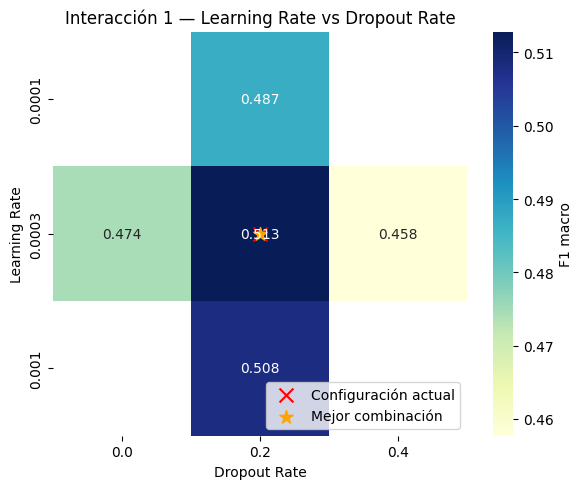

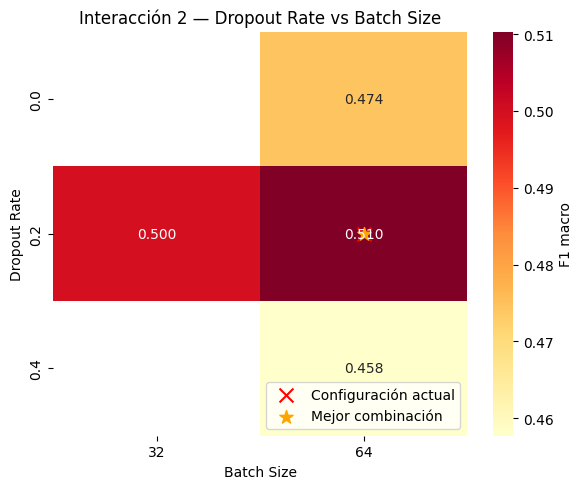

Mejor combinación (lr, dropout_rate): (0.0003, 0.2) → F1=0.513
Mejor combinación (dropout_rate, batch_size): (0.2, 64) → F1=0.510


In [35]:
# ============================================================
# 6.7 — Análisis de Interacciones entre Hiperparámetros
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ------------- Interacción 1: lr × dropout_rate -----------------
pivot_1 = df_oat.pivot_table(
    index="lr", columns="dropout_rate", values="f1_macro_val", aggfunc="mean"
)

plt.figure(figsize=(6, 5))
sns.heatmap(pivot_1, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'F1 macro'})
plt.title("Interacción 1 — Learning Rate vs Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Learning Rate")

# Mejor combinación
best_lr, best_drop = np.unravel_index(np.nanargmax(pivot_1.values), pivot_1.shape)
best_lr_val = pivot_1.index[best_lr]
best_drop_val = pivot_1.columns[best_drop]
best_f1 = pivot_1.values[best_lr, best_drop]

# Marcar mejor combinación y baseline
plt.scatter(np.where(pivot_1.columns == BASELINE["dropout_rate"])[0][0] + 0.5,
            np.where(pivot_1.index == BASELINE["lr"])[0][0] + 0.5,
            s=100, c="red", marker="x", label="Configuración actual")
plt.scatter(best_drop + 0.5, best_lr + 0.5, s=100, c="orange", marker="*", label="Mejor combinación")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ------------- Interacción 2: dropout_rate × batch_size -----------------
pivot_2 = df_oat.pivot_table(
    index="dropout_rate", columns="batch_size", values="f1_macro_val", aggfunc="mean"
)

plt.figure(figsize=(6, 5))
sns.heatmap(pivot_2, annot=True, fmt=".3f", cmap="YlOrRd", cbar_kws={'label': 'F1 macro'})
plt.title("Interacción 2 — Dropout Rate vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Dropout Rate")

# Mejor combinación
best_drop2, best_batch = np.unravel_index(np.nanargmax(pivot_2.values), pivot_2.shape)
best_drop2_val = pivot_2.index[best_drop2]
best_batch_val = pivot_2.columns[best_batch]
best_f1_2 = pivot_2.values[best_drop2, best_batch]

# Marcar mejor combinación y baseline
plt.scatter(np.where(pivot_2.columns == BASELINE["batch_size"])[0][0] + 0.5,
            np.where(pivot_2.index == BASELINE["dropout_rate"])[0][0] + 0.5,
            s=100, c="red", marker="x", label="Configuración actual")
plt.scatter(best_batch + 0.5, best_drop2 + 0.5, s=100, c="orange", marker="*", label="Mejor combinación")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Mejor combinación (lr, dropout_rate): ({best_lr_val}, {best_drop_val}) → F1={best_f1:.3f}")
print(f"Mejor combinación (dropout_rate, batch_size): ({best_drop2_val}, {best_batch_val}) → F1={best_f1_2:.3f}")


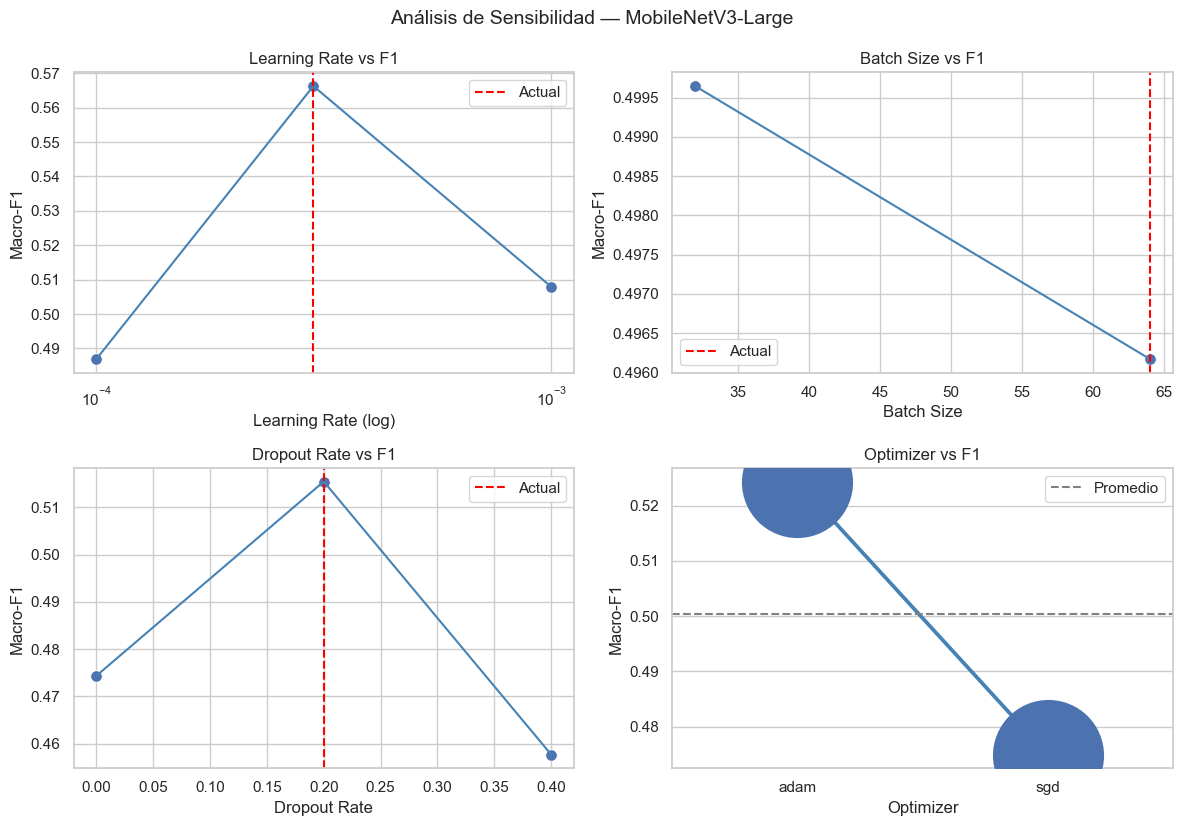

 Imagen guardada en alta resolución: analisis_sensibilidad_dispersion_hd.png


In [39]:
# ============================================================
# 6.6 — Gráficos de Sensibilidad Individual (Partial Dependence)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", font_scale=1.0)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# --- 1. Learning Rate ---
ax = axes[0, 0]
sns.scatterplot(data=df_oat[df_oat["hp"] == "lr"], x="lr", y="f1_macro_val", ax=ax, s=70)
sns.lineplot(data=df_oat[df_oat["hp"] == "lr"], x="lr", y="f1_macro_val", ax=ax, color="steelblue")
ax.axvline(BASELINE["lr"], color="red", linestyle="--", label="Actual")
ax.set_xscale("log")
ax.set_title("Learning Rate vs F1")
ax.set_xlabel("Learning Rate (log)")
ax.set_ylabel("Macro-F1")
ax.legend()

# --- 2. Batch Size ---
ax = axes[0, 1]
sns.scatterplot(data=df_oat[df_oat["hp"] == "batch_size"], x="batch_size", y="f1_macro_val", ax=ax, s=70)
sns.lineplot(data=df_oat[df_oat["hp"] == "batch_size"], x="batch_size", y="f1_macro_val", ax=ax, color="steelblue")
ax.axvline(BASELINE["batch_size"], color="red", linestyle="--", label="Actual")
ax.set_title("Batch Size vs F1")
ax.set_xlabel("Batch Size")
ax.set_ylabel("Macro-F1")
ax.legend()

# --- 3. Dropout Rate ---
ax = axes[1, 0]
sns.scatterplot(data=df_oat[df_oat["hp"] == "dropout_rate"], x="dropout_rate", y="f1_macro_val", ax=ax, s=70)
sns.lineplot(data=df_oat[df_oat["hp"] == "dropout_rate"], x="dropout_rate", y="f1_macro_val", ax=ax, color="steelblue")
ax.axvline(BASELINE["dropout_rate"], color="red", linestyle="--", label="Actual")
ax.set_title("Dropout Rate vs F1")
ax.set_xlabel("Dropout Rate")
ax.set_ylabel("Macro-F1")
ax.legend()

# --- 4. Optimizer ---
ax = axes[1, 1]
sns.stripplot(data=df_oat[df_oat["hp"] == "optimizer"], x="optimizer", y="f1_macro_val", ax=ax, s=80, jitter=False)
sns.pointplot(data=df_oat[df_oat["hp"] == "optimizer"], x="optimizer", y="f1_macro_val", ax=ax, color="steelblue", markers="o")
ax.axhline(df_oat["f1_macro_val"].mean(), color="gray", linestyle="--", label="Promedio")
ax.set_title("Optimizer vs F1")
ax.set_xlabel("Optimizer")
ax.set_ylabel("Macro-F1")
ax.legend()

plt.tight_layout()
plt.suptitle("Análisis de Sensibilidad — MobileNetV3-Large", fontsize=14, y=1.03)

# === Guardado local seguro (usa ruta válida en tu sistema) ===
plt.savefig("analisis_sensibilidad_dispersion_hd.png", dpi=300, bbox_inches="tight")
plt.show()

print(" Imagen guardada en alta resolución: analisis_sensibilidad_dispersion_hd.png")
